# **ソフトウェア欠陥データセットによるバイナリ分類**
(Binary Classification with a Software Defects Dataset)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e23/sample_submission.csv
/kaggle/input/playground-series-s3e23/train.csv
/kaggle/input/playground-series-s3e23/test.csv


# 参考資料
**書籍**
- Python実践データ加工:可視化100本ノック
- ［第3版］Python機械学習プログラミング 達人データサイエンティストによる理論と実践


**Kaggle**
- [PSS3E23 EDA which makes sense ⭐️⭐️⭐️⭐️⭐️](https://www.kaggle.com/code/ambrosm/pss3e23-eda-which-makes-sense)
- [PS_3.23_LGBM_bin_日本語あり](https://www.kaggle.com/code/akioonodera/ps-3-23-lgbm-bin)
- [PS3E23 | Binary Classification for Beginners](https://www.kaggle.com/code/iqbalsyahakbar/ps3e23-binary-classification-for-beginners)

**記事**  

**自分で作成したファイル**
- モース硬度データセットを使用した回帰
- 生体信号を使用した喫煙者の状態のバイナリ予測

## 概要
1. 目的： ソフトウェアの欠陥確率を予測する
2. 目次:
    * ライブラリ・データセットのインポート
    * EDA  
3. 目的変数： defects(bool)

### 各特徴量の日本語訳
#### Japanese
データセットの9つのカラムは「導出された指標」
- P = volume = V = N * log2(mu) (長さNのプログラムを書くために必要な精神的比較の数)
- V* = minimal implementationでのvolume = (2 + mu2')*log2(2 + mu2')
- L  = プログラムの長さ = V*/N
- D  = 難易度 = 1/L
- L' = 1/D
- I  = 知能 = L'*V'
- E  = プログラムを書くための労力 = V/L
- T  = プログラムを書くのにかかる時間 = E/18 秒

#### 評価指標：　Area Under the ROC Curve(AUC)
- ROC曲線に基づくモデルの評価指標
- ROC曲線と横軸で囲まれる面積の値
- 大小比較を行い相対的な順番を与える
- 不均衡データ（imbalanced data）下におけるモデルの評価時にも耐えられる指標

# ライブラリ・データセットのインポート

In [2]:
!pip install sweetviz
!pip install category_encoders

  Obtaining dependency information for sweetviz from https://files.pythonhosted.org/packages/89/50/8d3f7ca820267a38b42c64778db0f186d85cec6e3f0c5210eab9c16e783f/sweetviz-2.3.1-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 56.1 MB/s eta 0:00:00:00:0100:01


In [3]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import norm, skew

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
from IPython.display import display
import sweetviz as sv

import warnings; warnings.filterwarnings("ignore")

pd.options.display.float_format = '{:.5f}'.format
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
plt.style.use('ggplot')

In [4]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
import missingno as msno

from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier # 特徴量の重要度評価で用いる

# 敵対性の検証で用いる
from category_encoders import OneHotEncoder
from sklearn.model_selection import  StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier

## 実行時間を調べるために使う

In [6]:
import datetime
import time
import math

start_time = time.time()

def changeHMS(s):
    h = math.floor(s / 3600)
    if h > 0:
        s = s - h * 3600
        indi_h = str(h) + 'h'
    else:
        indi_h = ''
    m = math.floor(s / 60)
    if m > 0:
        indi_m = str(m) + 'm'
    else:
        indi_m = ''
    s = math.floor(s % 60)
    time = indi_h + indi_m + str(s) + 's'
    return time

In [7]:
FILE_PATH = '/kaggle/input/playground-series-s3e23/'
OUTPUT_DIR = '/kaggle/working/'
train = pd.read_csv(FILE_PATH + 'train.csv')
test = pd.read_csv(FILE_PATH + 'test.csv')

In [8]:
train_id = train['id']
train.drop('id', axis=1, inplace=True)

test_id = test['id']
test.drop('id', axis=1, inplace=True)

target = train['defects']
target_col = 'defects'
target_name = str(train.iloc[:, [-1]].columns.tolist())

## データ(DataFrame)の構成を調べる

In [9]:
train.head()

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,b,t,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
0,22.00000,3.00000,1.00000,2.00000,60.00000,278.63000,0.06000,19.56000,14.25000,5448.79000,0.09000,302.71000,17,1,1,0,16.00000,9.00000,38.00000,22.00000,5.00000,False
1,14.00000,2.00000,1.00000,2.00000,32.00000,151.27000,0.14000,7.00000,21.11000,936.71000,0.05000,52.04000,11,0,1,0,11.00000,11.00000,18.00000,14.00000,3.00000,False
2,11.00000,2.00000,1.00000,2.00000,45.00000,197.65000,0.11000,8.05000,22.76000,1754.01000,0.07000,97.45000,8,0,1,0,12.00000,11.00000,28.00000,17.00000,3.00000,False
3,8.00000,1.00000,1.00000,1.00000,23.00000,94.01000,0.19000,5.25000,17.86000,473.66000,0.03000,26.31000,4,0,2,0,8.00000,6.00000,16.00000,7.00000,1.00000,True
4,11.00000,2.00000,1.00000,2.00000,17.00000,60.94000,0.18000,5.63000,12.44000,365.67000,0.02000,20.31000,7,0,2,0,7.00000,6.00000,10.00000,10.00000,3.00000,False


In [10]:
test.head()

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,b,t,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount
0,33.00000,5.00000,1.00000,4.00000,144.00000,824.82000,0.04000,26.96000,30.05000,22636.74000,0.27000,1257.60000,30,0,3,0,21.00000,23.00000,87.00000,57.00000,9.00000
1,27.00000,8.00000,8.00000,2.00000,125.00000,646.24000,0.04000,22.82000,27.22000,14482.46000,0.22000,804.58000,23,0,2,0,18.00000,19.00000,70.00000,49.00000,15.00000
2,130.00000,11.00000,7.00000,10.00000,545.00000,3831.40000,0.02000,48.15000,66.17000,116160.08000,1.28000,6453.34000,99,9,17,1,26.00000,53.00000,333.00000,244.00000,21.00000
3,65.00000,7.00000,1.00000,7.00000,156.00000,855.71000,0.06000,17.23000,49.89000,16135.47000,0.29000,896.42000,45,8,10,0,15.00000,26.00000,88.00000,60.00000,13.00000
4,22.00000,3.00000,1.00000,3.00000,52.00000,238.42000,0.10000,9.60000,26.70000,2624.49000,0.08000,145.80000,16,0,4,0,12.00000,15.00000,30.00000,24.00000,5.00000


In [11]:
print('train: ')
print(train.shape)
print(train.info())
print('\n')
print('test: ')
print(test.shape)
print(test.info())

train: 
(101763, 22)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101763 entries, 0 to 101762
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   loc                101763 non-null  float64
 1   v(g)               101763 non-null  float64
 2   ev(g)              101763 non-null  float64
 3   iv(g)              101763 non-null  float64
 4   n                  101763 non-null  float64
 5   v                  101763 non-null  float64
 6   l                  101763 non-null  float64
 7   d                  101763 non-null  float64
 8   i                  101763 non-null  float64
 9   e                  101763 non-null  float64
 10  b                  101763 non-null  float64
 11  t                  101763 non-null  float64
 12  lOCode             101763 non-null  int64  
 13  lOComment          101763 non-null  int64  
 14  lOBlank            101763 non-null  int64  
 15  locCodeAndComment  101763 non-

In [12]:
train_columns = train.columns
train_index = train.index
train_data = train.values # values

test_columns = test.columns
test_index = test.index
test_data = test.values # values

print('train: ')
print(type(train_columns))
print(type(train_index))
print(type(train_data))
print('\n')
print('test: ')
print(type(test_columns))
print(type(test_index))
print(type(test_data))

train: 
<class 'pandas.core.indexes.base.Index'>
<class 'pandas.core.indexes.range.RangeIndex'>
<class 'numpy.ndarray'>


test: 
<class 'pandas.core.indexes.base.Index'>
<class 'pandas.core.indexes.range.RangeIndex'>
<class 'numpy.ndarray'>


In [13]:
with pd.option_context('display.max_rows', 8):
    display(train)

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,b,t,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
0,22.00000,3.00000,1.00000,2.00000,60.00000,278.63000,0.06000,19.56000,14.25000,5448.79000,0.09000,302.71000,17,1,1,0,16.00000,9.00000,38.00000,22.00000,5.00000,False
1,14.00000,2.00000,1.00000,2.00000,32.00000,151.27000,0.14000,7.00000,21.11000,936.71000,0.05000,52.04000,11,0,1,0,11.00000,11.00000,18.00000,14.00000,3.00000,False
2,11.00000,2.00000,1.00000,2.00000,45.00000,197.65000,0.11000,8.05000,22.76000,1754.01000,0.07000,97.45000,8,0,1,0,12.00000,11.00000,28.00000,17.00000,3.00000,False
3,8.00000,1.00000,1.00000,1.00000,23.00000,94.01000,0.19000,5.25000,17.86000,473.66000,0.03000,26.31000,4,0,2,0,8.00000,6.00000,16.00000,7.00000,1.00000,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101759,27.00000,5.00000,4.00000,1.00000,107.00000,559.93000,0.06000,18.00000,34.17000,11268.27000,0.19000,626.01000,23,0,2,0,18.00000,20.00000,67.00000,40.00000,9.00000,False
101760,26.00000,1.00000,1.00000,1.00000,83.00000,360.17000,0.04000,22.75000,12.56000,5893.69000,0.12000,327.43000,20,0,4,0,10.00000,8.00000,51.00000,28.00000,1.00000,False
101761,10.00000,2.00000,1.00000,2.00000,43.00000,191.76000,0.15000,6.46000,29.53000,1534.04000,0.06000,85.22000,7,0,1,0,11.00000,14.00000,24.00000,19.00000,3.00000,False
101762,136.00000,18.00000,18.00000,1.00000,296.00000,1704.57000,0.02000,44.82000,44.08000,77011.02000,0.57000,4278.43000,102,1,11,0,22.00000,31.00000,162.00000,135.00000,35.00000,False


In [14]:
with pd.option_context('display.max_rows', 8):
    display(test)

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,b,t,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount
0,33.00000,5.00000,1.00000,4.00000,144.00000,824.82000,0.04000,26.96000,30.05000,22636.74000,0.27000,1257.60000,30,0,3,0,21.00000,23.00000,87.00000,57.00000,9.00000
1,27.00000,8.00000,8.00000,2.00000,125.00000,646.24000,0.04000,22.82000,27.22000,14482.46000,0.22000,804.58000,23,0,2,0,18.00000,19.00000,70.00000,49.00000,15.00000
2,130.00000,11.00000,7.00000,10.00000,545.00000,3831.40000,0.02000,48.15000,66.17000,116160.08000,1.28000,6453.34000,99,9,17,1,26.00000,53.00000,333.00000,244.00000,21.00000
3,65.00000,7.00000,1.00000,7.00000,156.00000,855.71000,0.06000,17.23000,49.89000,16135.47000,0.29000,896.42000,45,8,10,0,15.00000,26.00000,88.00000,60.00000,13.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67838,20.00000,3.00000,1.00000,3.00000,38.00000,161.42000,0.15000,6.75000,23.28000,1060.92000,0.05000,58.94000,15,0,3,0,9.00000,10.00000,23.00000,15.00000,5.00000
67839,24.00000,2.00000,1.00000,2.00000,52.00000,240.00000,0.11000,9.00000,26.67000,2160.00000,0.08000,120.00000,18,0,4,0,16.00000,16.00000,36.00000,18.00000,3.00000
67840,18.00000,2.00000,1.00000,1.00000,49.00000,216.64000,0.11000,9.33000,24.02000,2118.30000,0.08000,117.68000,12,0,2,0,8.00000,12.00000,29.00000,22.00000,3.00000
67841,101.00000,15.00000,10.00000,5.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,0,0,0.00000,0.00000,0.00000,0.00000,29.00000


In [15]:
print('train: ')
print(train.dtypes)
print(train.dtypes.value_counts())
print('\n')
print('test: ')
print(test.dtypes)
print(test.dtypes.value_counts())

train: 
loc                  float64
v(g)                 float64
ev(g)                float64
iv(g)                float64
n                    float64
v                    float64
l                    float64
d                    float64
i                    float64
e                    float64
b                    float64
t                    float64
lOCode                 int64
lOComment              int64
lOBlank                int64
locCodeAndComment      int64
uniq_Op              float64
uniq_Opnd            float64
total_Op             float64
total_Opnd           float64
branchCount          float64
defects                 bool
dtype: object
float64    17
int64       4
bool        1
Name: count, dtype: int64


test: 
loc                  float64
v(g)                 float64
ev(g)                float64
iv(g)                float64
n                    float64
v                    float64
l                    float64
d                    float64
i                    float64
e 

目的変数以外は数値（int64, float64）

In [16]:
# 説明変数をデータ型ごとに代入する
numerical_features = test._get_numeric_data().columns
categorical_features = test.drop(numerical_features, axis=1).columns
numerical_features, categorical_features

(Index(['loc', 'v(g)', 'ev(g)', 'iv(g)', 'n', 'v', 'l', 'd', 'i', 'e', 'b', 't',
        'lOCode', 'lOComment', 'lOBlank', 'locCodeAndComment', 'uniq_Op',
        'uniq_Opnd', 'total_Op', 'total_Opnd', 'branchCount'],
       dtype='object'),
 Index([], dtype='object'))

# EDA(探索的データ分析)

What's your EDA?  
**EDA(探索的データ分析)**: データセットに適宜前処理を施しつつ様々な統計量を抽出して可視化し、そこに内在する特性・パターン・偏りについて探索的に仮説立案・検証を繰り返して分析すること

## 要約統計量

In [17]:
train.describe().T \
.style.bar(subset=['mean'], color=px.colors.qualitative.G10[0]) \
.background_gradient(subset=['std'], cmap='Greens') \
.background_gradient(subset=['50%'], cmap='BuGn')

,count,mean,std,min,25%,50%,75%,max
loc,101763.000000,37.347160,54.600401,1.000000,13.000000,22.000000,42.000000,3442.000000
v(g),101763.000000,5.492684,7.900855,1.000000,2.000000,3.000000,6.000000,404.000000
ev(g),101763.000000,2.845022,4.631262,1.000000,1.000000,1.000000,3.000000,165.000000
iv(g),101763.000000,3.498826,5.534541,1.000000,1.000000,2.000000,4.000000,402.000000
n,101763.000000,96.655995,171.147191,0.000000,25.000000,51.000000,111.000000,8441.000000
v,101763.000000,538.280956,1270.791601,0.000000,97.670000,232.790000,560.250000,80843.080000
l,101763.000000,0.111634,0.100096,0.000000,0.050000,0.090000,0.150000,1.000000
d,101763.000000,13.681881,14.121306,0.000000,5.600000,9.820000,18.000000,418.200000
i,101763.000000,27.573007,22.856742,0.000000,15.560000,23.360000,34.340000,569.780000
e,101763.000000,20853.589876,190571.405427,0.000000,564.730000,2256.230000,10193.240000,16846621.120000


In [18]:
test.describe().T \
.style.bar(subset=['mean'], color=px.colors.qualitative.G10[0]) \
.background_gradient(subset=['std'], cmap='Greens') \
.background_gradient(subset=['50%'], cmap='BuGn')

,count,mean,std,min,25%,50%,75%,max
loc,67842.000000,37.855945,55.793918,1.000000,13.000000,22.000000,42.000000,1891.000000
v(g),67842.000000,5.559462,8.237389,1.000000,2.000000,3.000000,6.000000,470.000000
ev(g),67842.000000,2.857699,4.666370,1.000000,1.000000,1.000000,3.000000,165.000000
iv(g),67842.000000,3.535715,5.339085,1.000000,1.000000,2.000000,4.000000,402.000000
n,67842.000000,98.222178,179.123492,0.000000,25.000000,51.000000,111.000000,8441.000000
v,67842.000000,548.422497,1318.416828,0.000000,96.210000,232.790000,560.250000,80843.080000
l,67842.000000,0.111521,0.100840,0.000000,0.040000,0.090000,0.140000,1.000000
d,67842.000000,13.762472,14.487425,0.000000,5.500000,9.820000,18.000000,418.200000
i,67842.000000,27.635377,23.420521,0.000000,15.540000,23.230000,34.270000,569.780000
e,67842.000000,22164.320048,207276.970847,0.000000,562.940000,2276.780000,10112.427500,16846621.120000


In [19]:
desc_train = pd.DataFrame(index=list(train))
desc_train['count'] = train.count()
desc_train['nunique'] = train.nunique()
desc_train['%unique'] = desc_train['nunique'] / len(train) * 100
desc_train['null'] = train.isnull().sum()
desc_train['type'] = train.dtypes
desc_train = desc_train.style.background_gradient(cmap='Greens')
# desc_train = pd.concat([desc_train, train.describe().T], axis=1)
desc_train

,count,nunique,%unique,null,type
loc,101763,378,0.371451,0,float64
v(g),101763,106,0.104164,0,float64
ev(g),101763,71,0.069770,0,float64
iv(g),101763,84,0.082545,0,float64
n,101763,836,0.821517,0,float64
v,101763,4515,4.436780,0,float64
l,101763,55,0.054047,0,float64
d,101763,3360,3.301789,0,float64
i,101763,5171,5.081415,0,float64
e,101763,8729,8.577774,0,float64


In [20]:
desc_test = pd.DataFrame(index=list(test))
desc_test['count'] = test.count()
desc_test['nunique'] = test.nunique()
desc_test['%unique'] = desc_test['nunique'] / len(test) * 100
desc_test['null'] = test.isnull().sum()
desc_test['type'] = test.dtypes
desc_test = desc_test.style.background_gradient(cmap='Blues')
# desc_test = pd.concat([desc_test, test.describe().T], axis=1)
desc_test

,count,nunique,%unique,null,type
loc,67842,371,0.546859,0,float64
v(g),67842,96,0.141505,0,float64
ev(g),67842,67,0.098759,0,float64
iv(g),67842,73,0.107603,0,float64
n,67842,828,1.220483,0,float64
v,67842,4269,6.292562,0,float64
l,67842,54,0.079597,0,float64
d,67842,3106,4.578285,0,float64
i,67842,4855,7.156334,0,float64
e,67842,8160,12.027947,0,float64


In [21]:
# 特定の次元方向についての分散
print('train: ')
print(np.var(train[numerical_features], axis=0))
print('\n')
print('test: ')
print(np.var(test[numerical_features], axis=0))

train: 
loc                        2981.17453
v(g)                         62.42290
ev(g)                        21.44837
iv(g)                        30.63084
n                         29291.07312
v                       1614895.42465
l                             0.01002
d                           199.40932
i                           522.42553
e                   36317103683.52072
b                             0.17795
t                      97273778.62048
lOCode                     1485.39483
lOComment                    34.83812
lOBlank                      40.73410
locCodeAndComment             0.99780
uniq_Op                      45.55597
uniq_Opnd                   326.31432
total_Op                  10928.01502
total_Opnd                 5139.73663
branchCount                 207.72587
dtype: float64


test: 
loc                        3112.91544
v(g)                         67.85358
ev(g)                        21.77469
iv(g)                        28.50541
n                 

### 変動係数

変動係数は、標準偏差を平均値で割った値
* スケールに依存せず、比較できるようになる

In [22]:
train[numerical_features].std() / train[numerical_features].mean()

loc                 1.46197
v(g)                1.43843
ev(g)               1.62785
iv(g)               1.58183
n                   1.77068
v                   2.36083
l                   0.89665
d                   1.03212
i                   0.82895
e                   9.13854
b                   2.35451
t                   8.64128
lOCode              1.69021
lOComment           3.32728
lOBlank             1.60366
locCodeAndComment   5.08081
uniq_Op             0.56737
uniq_Opnd           1.15821
total_Op            1.81400
total_Opnd          1.82657
branchCount         1.46478
dtype: float64

## 尖度（せんど）と歪度（わいど）

- 分布が正規分布からどれだけ歪んでいるかを表す統計量で、左右対称性を示す指標のこと
- 分布が正規分布からどれだけ尖っているかを表す統計量で、山の尖り度と裾の広がり度

In [23]:
print('train: ')
print(train[numerical_features].kurtosis())
print('\n')
print('test: ')
print(test[numerical_features].kurtosis())

train: 
loc                  352.16512
v(g)                 501.42626
ev(g)                 96.03781
iv(g)               1564.10878
n                    209.57366
v                    518.21261
l                      5.03195
d                     92.42227
i                     57.40889
e                   2887.02912
b                    533.05155
t                   2780.01698
lOCode               633.77852
lOComment            353.06290
lOBlank              166.02371
locCodeAndComment    220.28736
uniq_Op              274.16096
uniq_Opnd            502.41935
total_Op             264.10462
total_Opnd           225.72430
branchCount          179.05324
dtype: float64


test: 
loc                  189.51814
v(g)                 506.80554
ev(g)                 93.19933
iv(g)               1199.44658
n                    214.36847
v                    521.21970
l                      5.33338
d                     85.79239
i                     66.80848
e                   2743.44723
b      

### 目的変数の尖度と歪度

In [25]:
# skewness and kurtosis
print("尖度: %f" % target.skew())
print("歪度: %f" % target.kurt())

尖度: 1.305878
歪度: -0.294689


## 欠損値

In [26]:
print('train: ')
print(train.isna().sum().any())
print(train.isnull().sum())
print('\n')
print('test: ')
print(test.isna().sum().any())
print(test.isnull().sum())

train: 
False
loc                  0
v(g)                 0
ev(g)                0
iv(g)                0
n                    0
v                    0
l                    0
d                    0
i                    0
e                    0
b                    0
t                    0
lOCode               0
lOComment            0
lOBlank              0
locCodeAndComment    0
uniq_Op              0
uniq_Opnd            0
total_Op             0
total_Opnd           0
branchCount          0
defects              0
dtype: int64


test: 
False
loc                  0
v(g)                 0
ev(g)                0
iv(g)                0
n                    0
v                    0
l                    0
d                    0
i                    0
e                    0
b                    0
t                    0
lOCode               0
lOComment            0
lOBlank              0
locCodeAndComment    0
uniq_Op              0
uniq_Opnd            0
total_Op             0
total_Opnd     

Axes(0.125,0.11;0.698618x0.77)
Axes(0.125,0.11;0.698618x0.77)


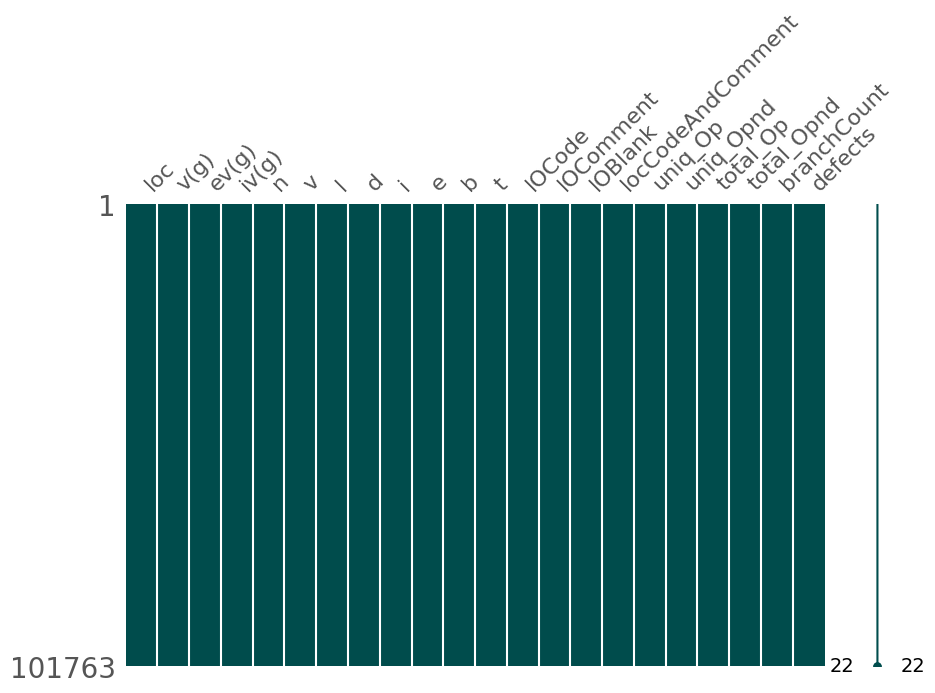

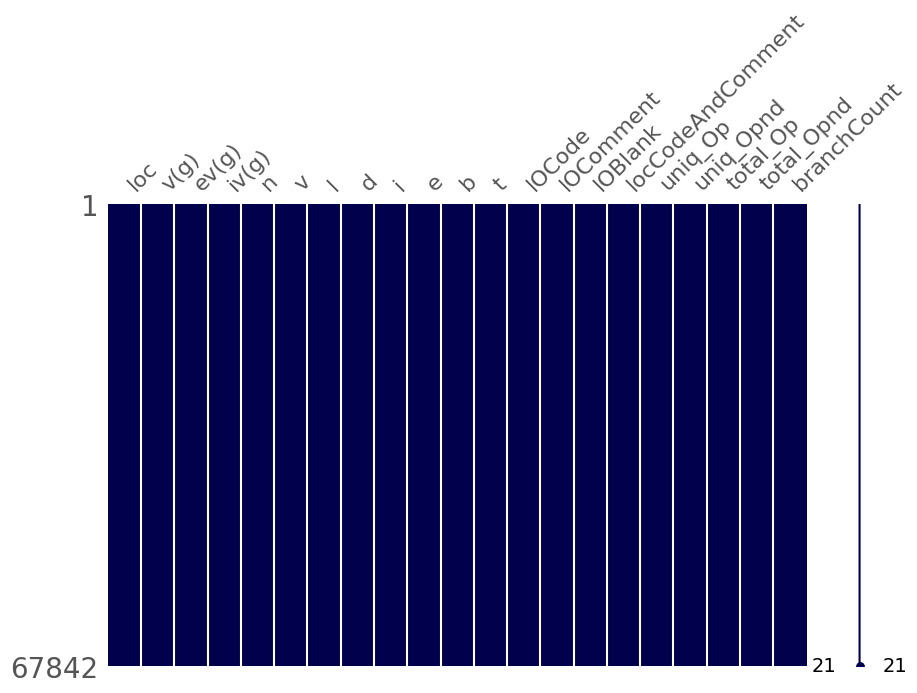

In [27]:
# 欠損値の有無を可視化する
print(msno.matrix(df=train, figsize=(10, 6), color=(0, .3, .3)))
print(msno.matrix(df=test, figsize=(10, 6), color=(0, 0, .3)))

元々欠損値がないデータ

## 重複データ

In [28]:
total = pd.concat([train.drop(target_col, axis=1), test], axis=0) # 目的変数を指定する
total.duplicated().sum()

0

## カラムごとのユニークな値を調べる

In [29]:
train[train.columns].nunique().sort_values(ascending=True)

defects                 2
locCodeAndComment      29
l                      55
uniq_Op                70
ev(g)                  71
iv(g)                  84
lOComment              91
lOBlank                94
v(g)                  106
branchCount           144
uniq_Opnd             176
lOCode                298
b                     315
loc                   378
total_Opnd            485
total_Op              623
n                     836
d                    3360
v                    4515
i                    5171
t                    8608
e                    8729
dtype: int64

### 目的変数

In [30]:
print(target_name +' Class labels:', np.unique(target))

['defects'] Class labels: [False  True]


## データセットのプロット（分布）

### 密度関数（ヒストグラム）

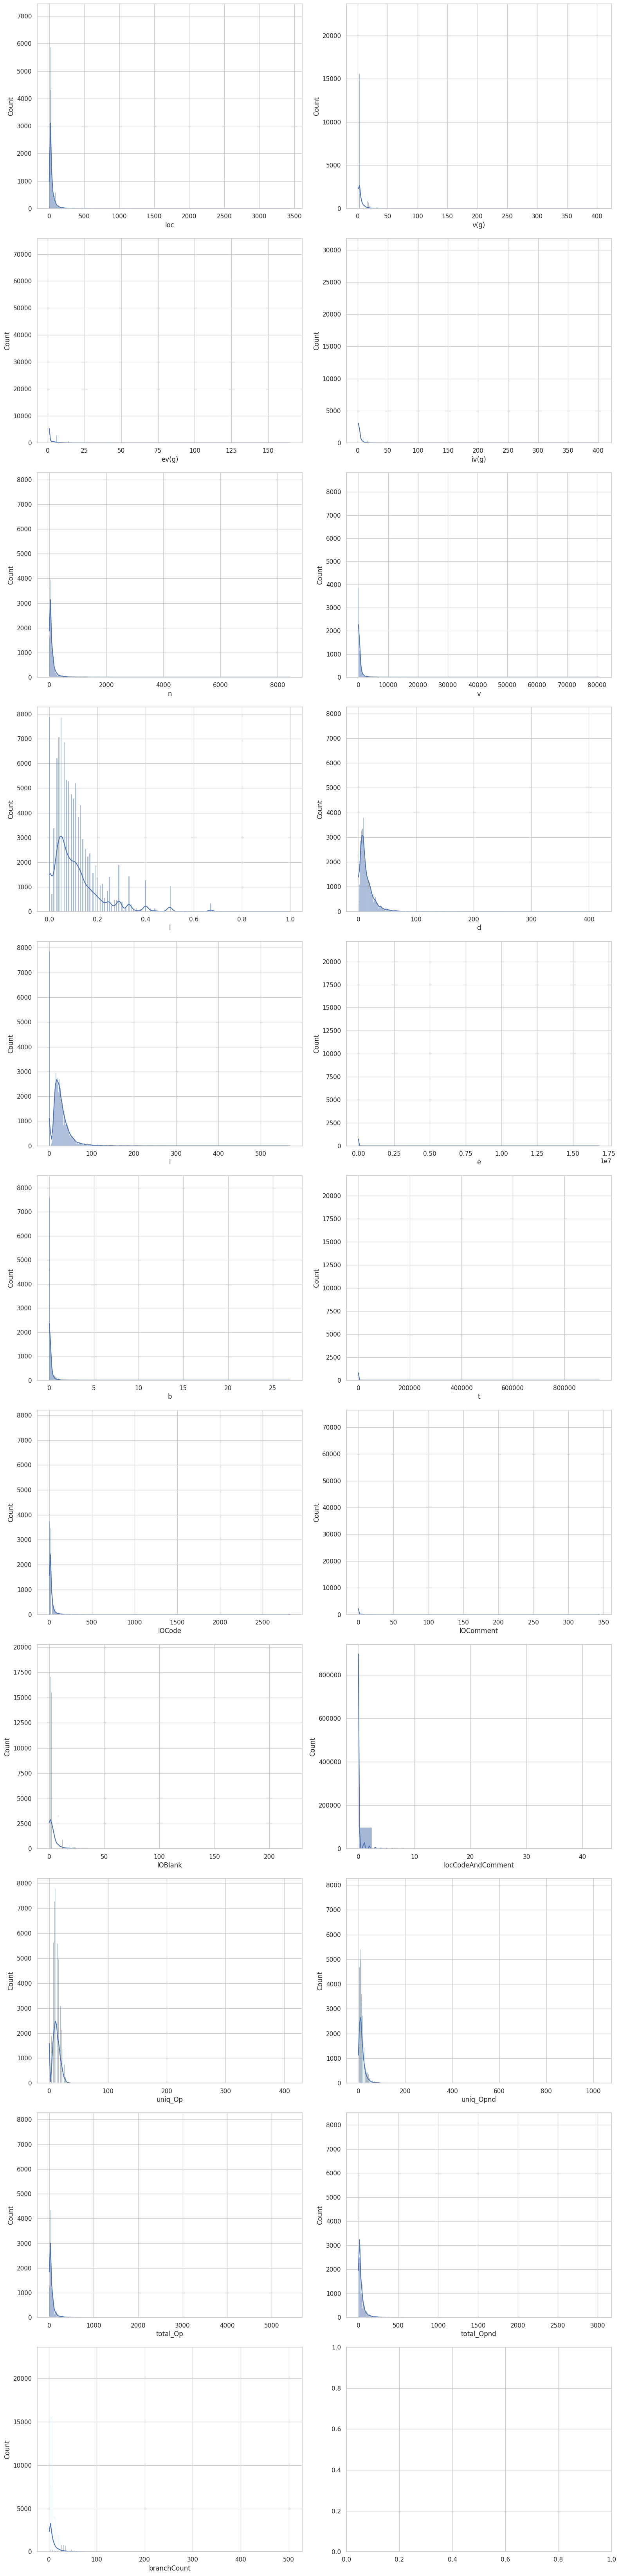

In [31]:
sns.set(style="whitegrid")

rows = (len(numerical_features) + 1) // 2
cols = 2
_, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(8 * cols, 6 * rows))

for i, feature_name in enumerate(numerical_features):
    row_idx, col_idx = divmod(i, cols)
    sns.histplot(data=train, x=feature_name, kde=True, ax=axes[row_idx, col_idx])

plt.tight_layout()

plt.show()

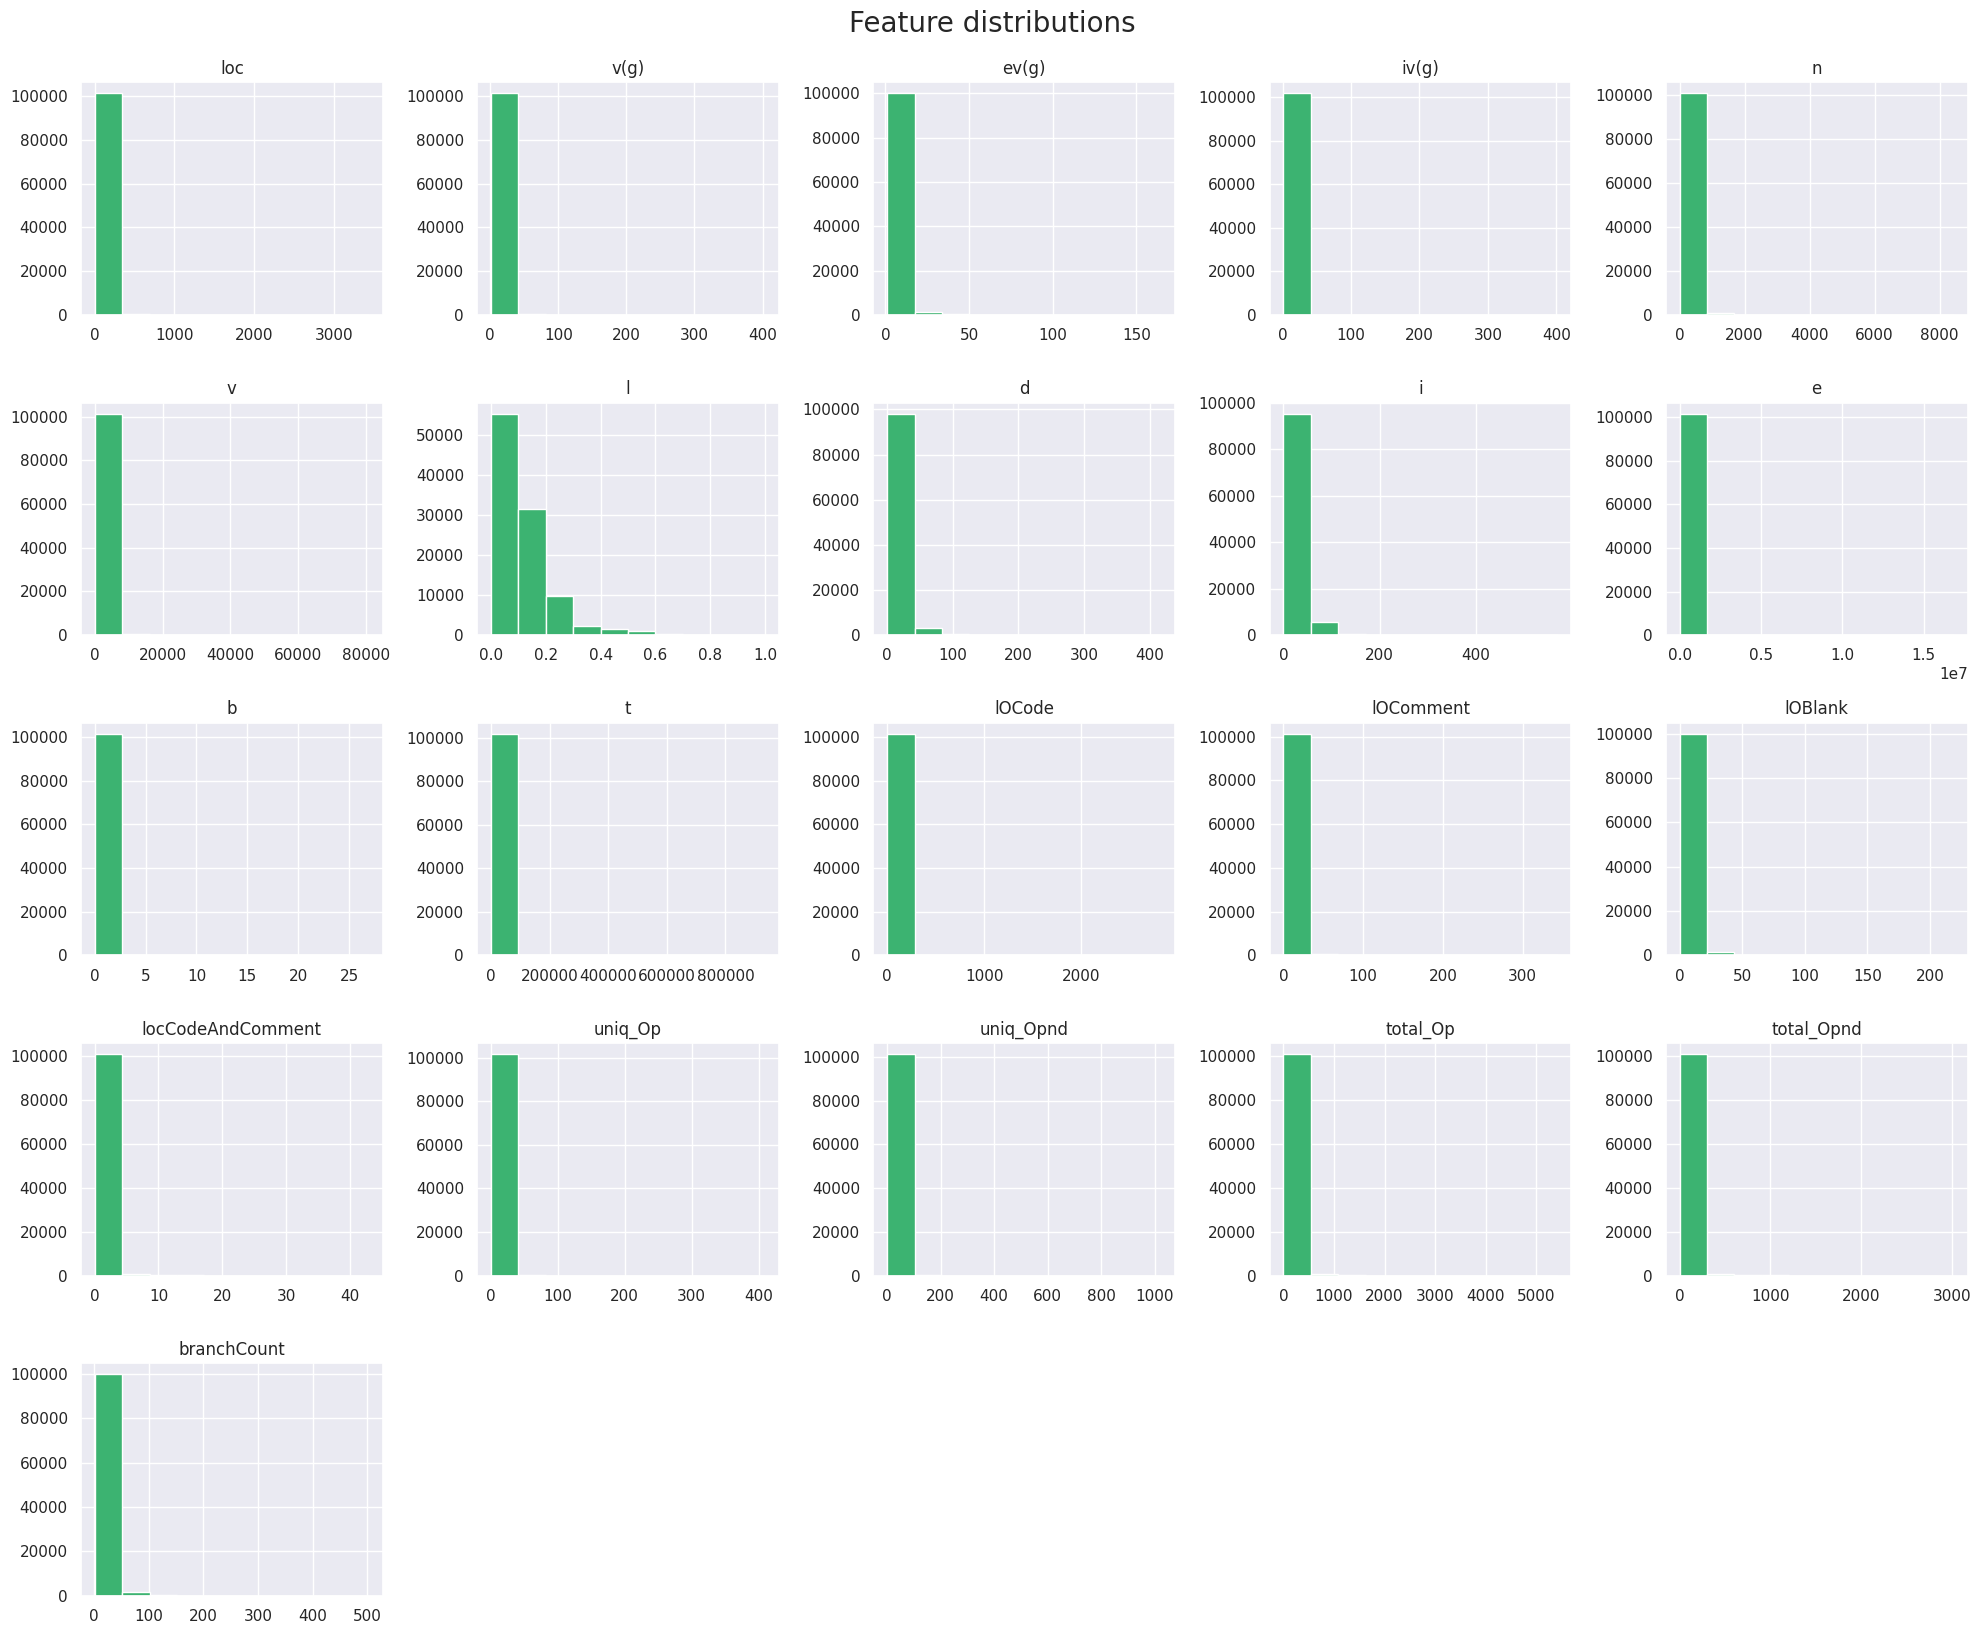

In [32]:
sns.set(rc={'figure.figsize': (20, 16)})
train.hist(color='mediumseagreen')
plt.tight_layout()
plt.suptitle('Feature distributions', y=1.02, fontsize=20)
plt.show()

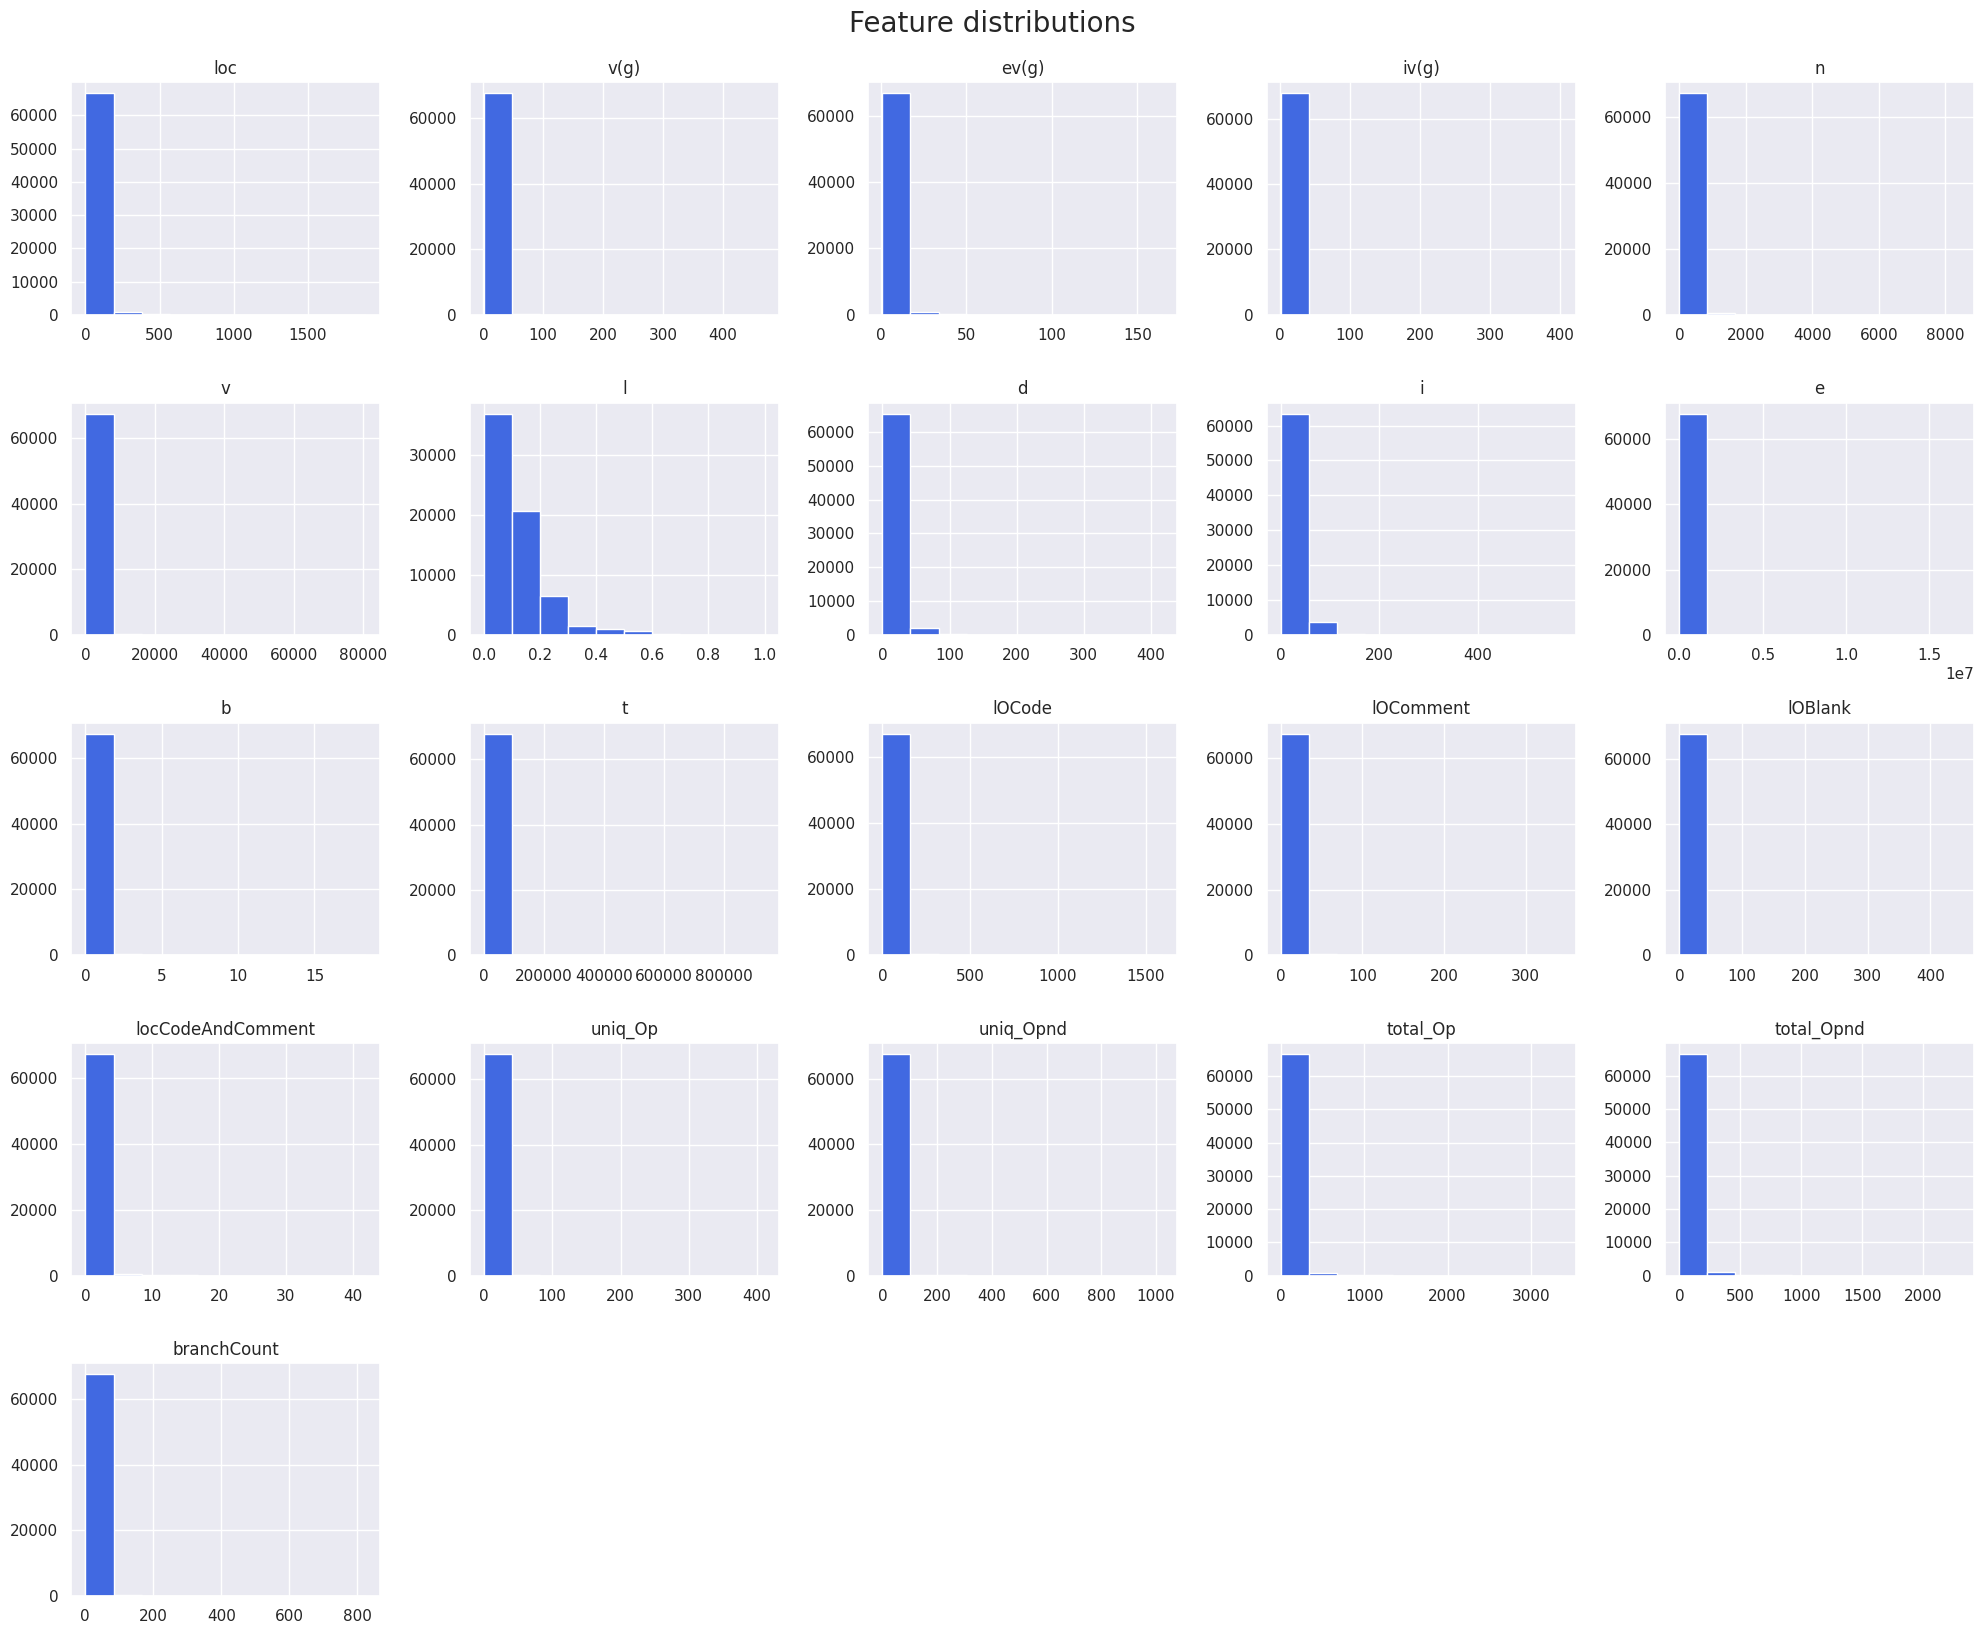

In [33]:
sns.set(rc={'figure.figsize': (20, 16)})
test.hist(color='royalblue')
plt.tight_layout()
plt.suptitle('Feature distributions', y=1.02, fontsize=20)
plt.show()

#### データの分布を可視化する

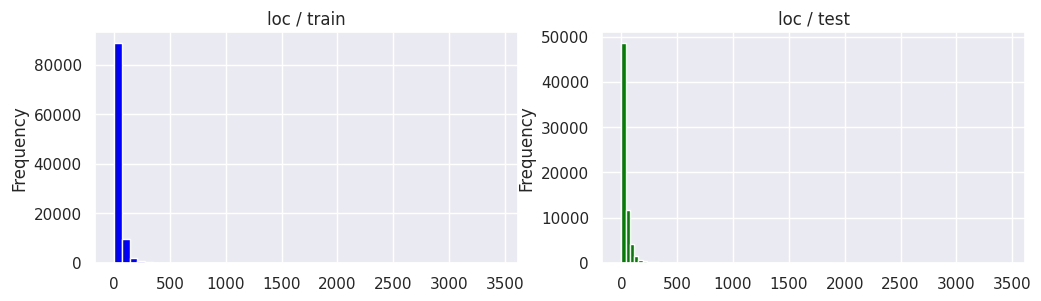

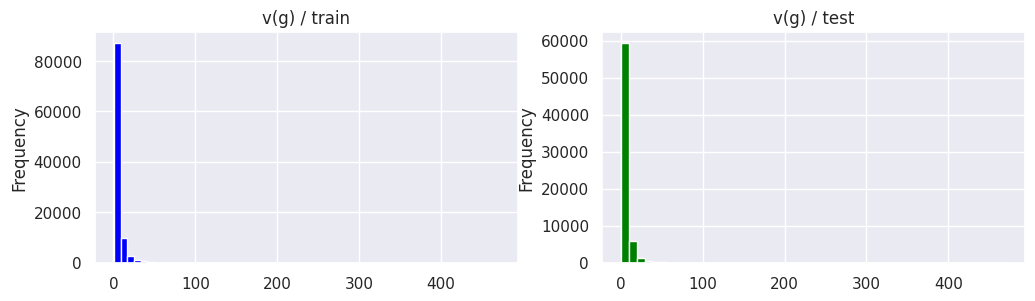

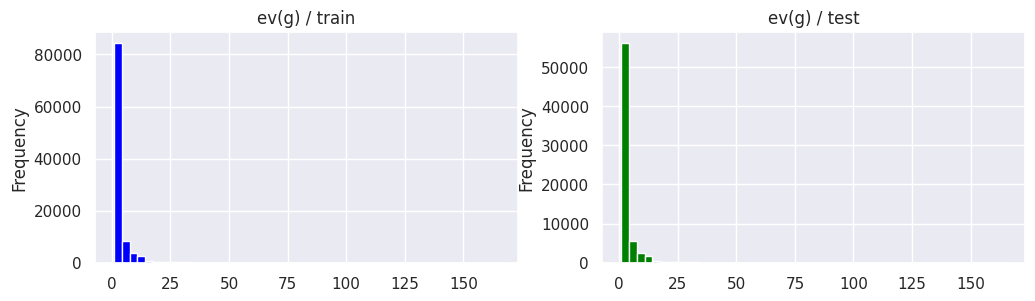

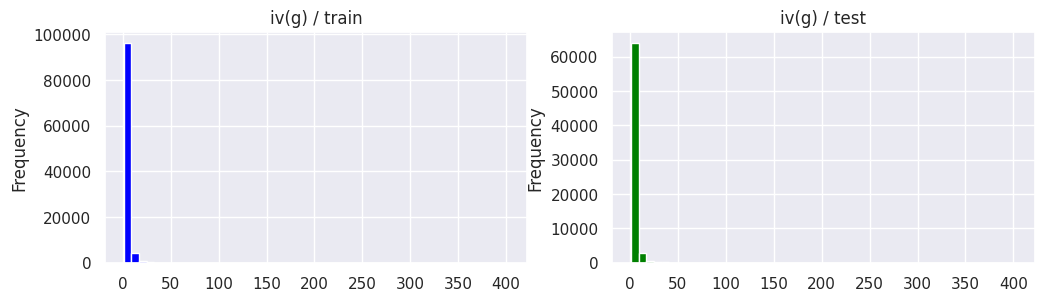

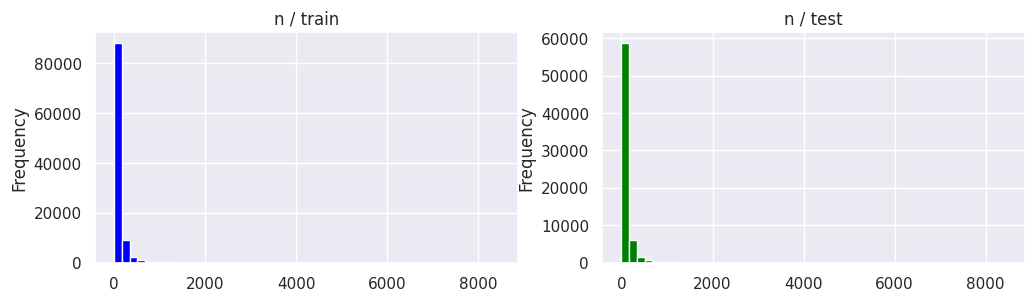

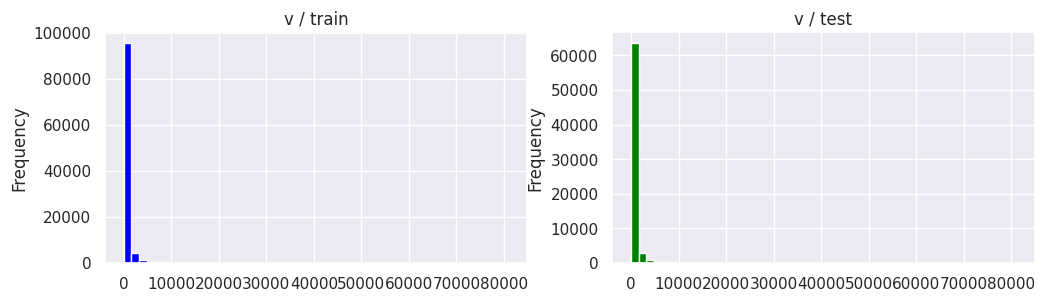

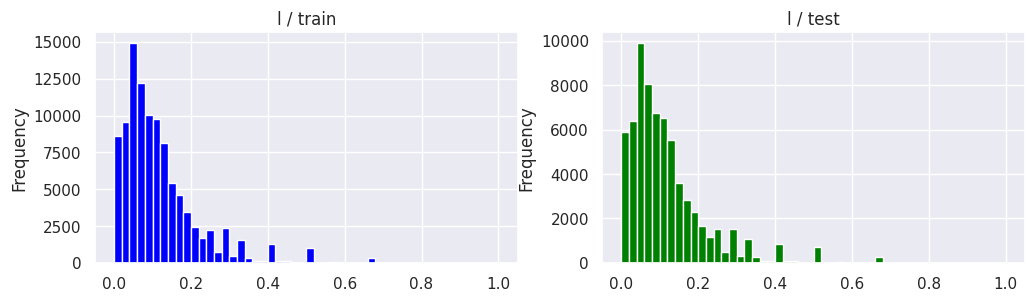

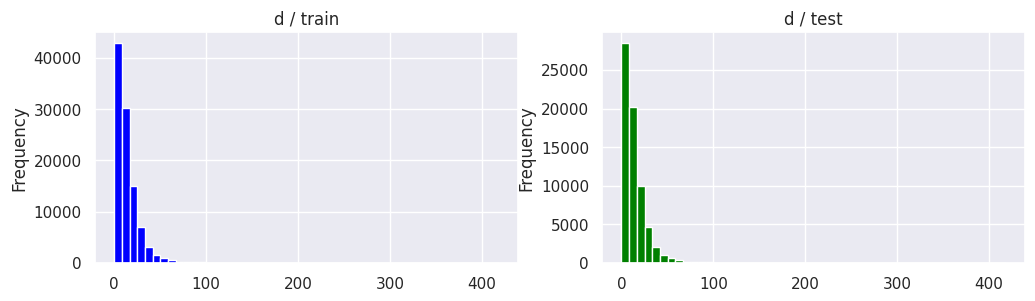

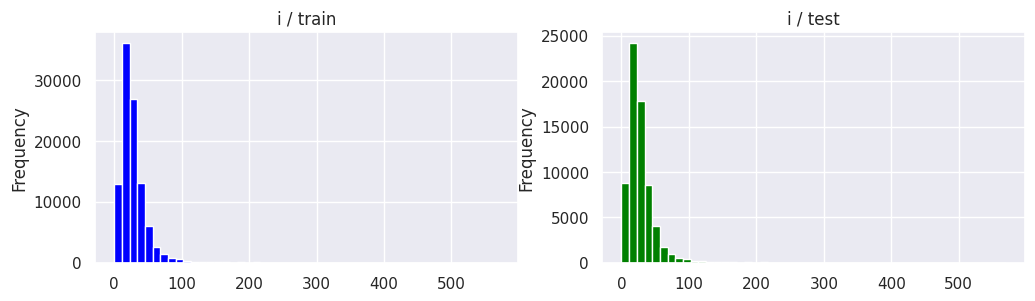

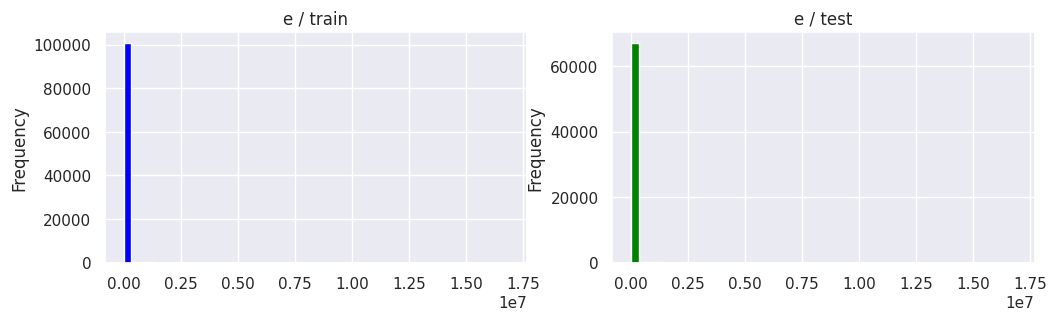

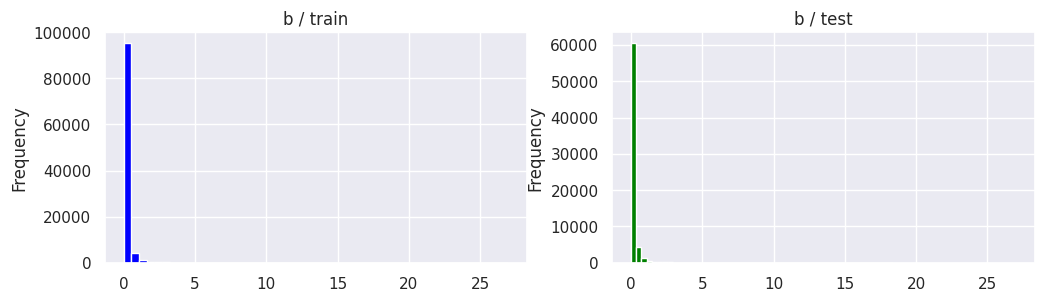

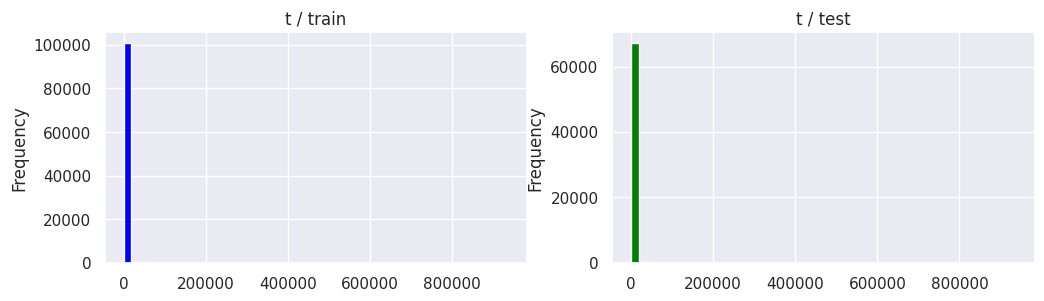

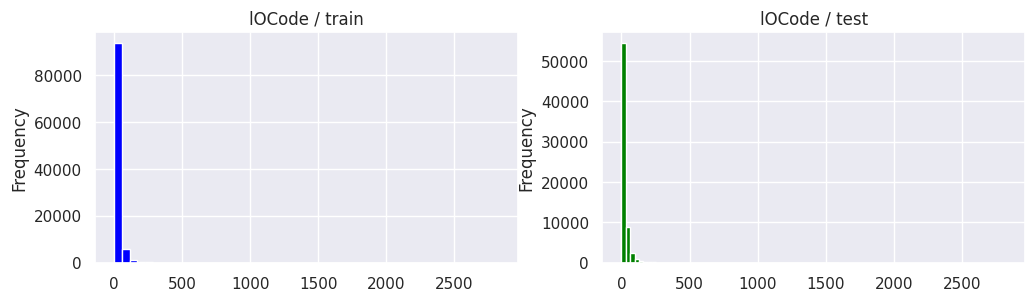

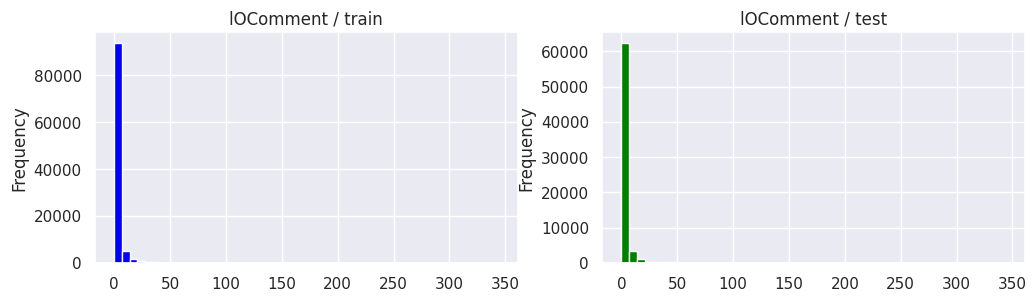

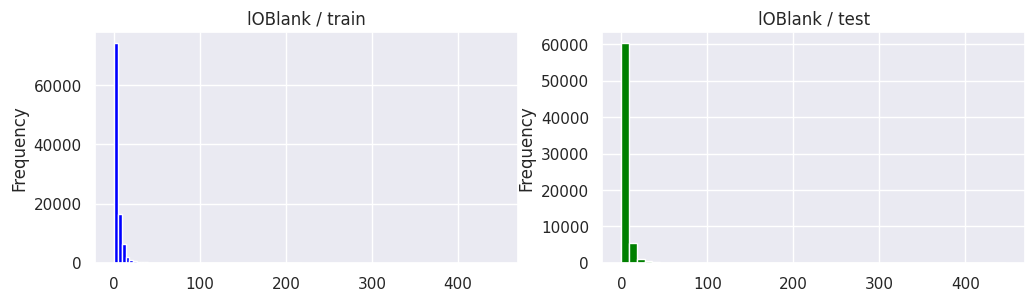

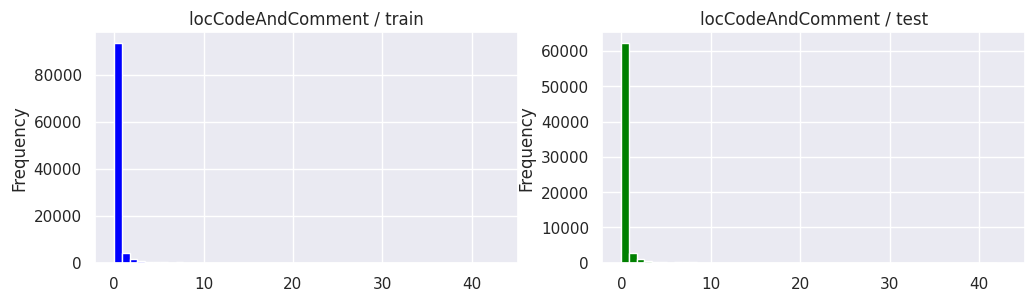

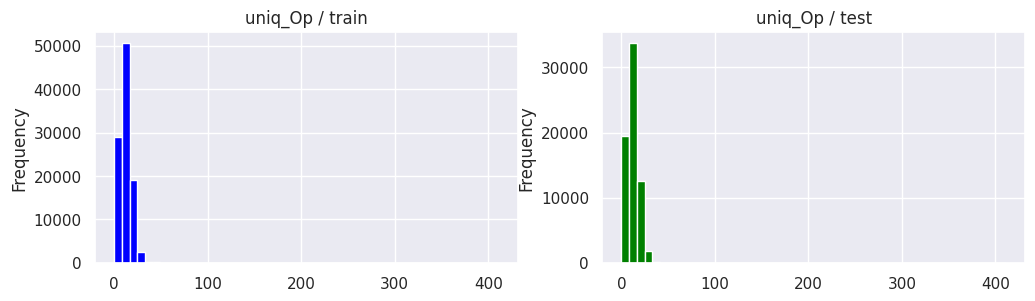

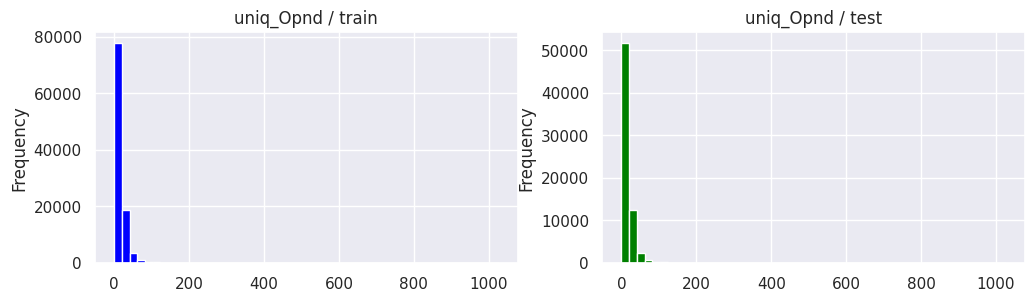

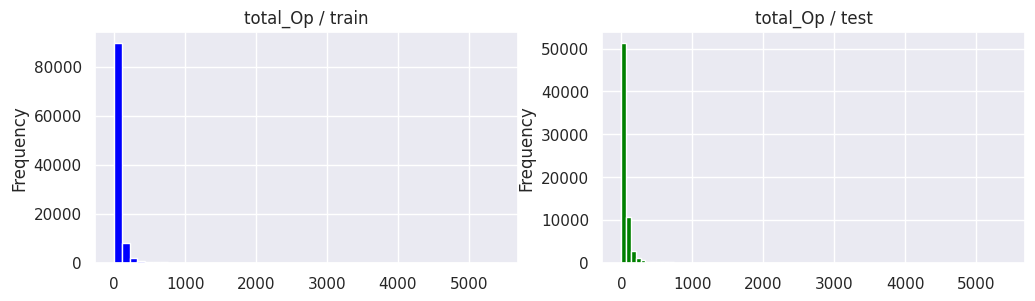

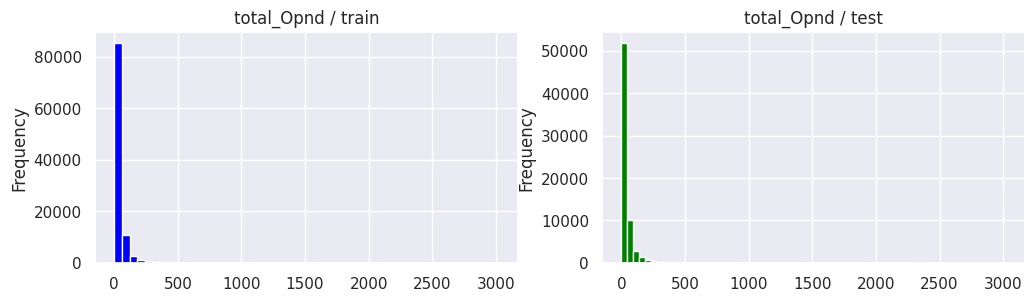

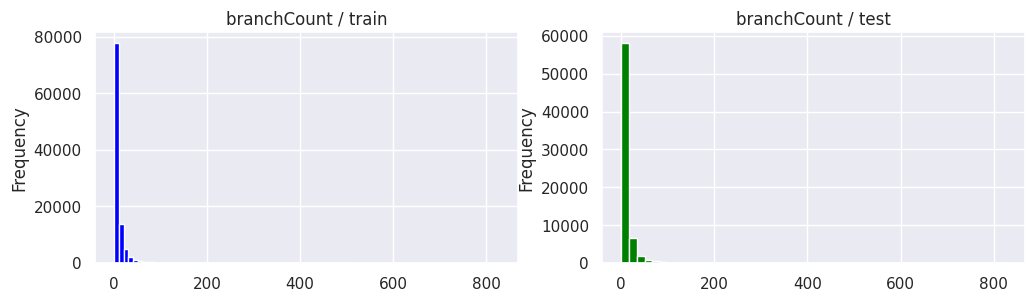

In [34]:
feature = train[numerical_features]

for feat in feature:
    plt.figure(figsize=(12, 3))
    ax1 = plt.subplot(1, 2, 1)
    train[feat].plot(kind='hist', bins=50, color='blue')
    plt.title(feat + ' / train')
    ax2 = plt.subplot(1, 2, 2, sharex=ax1)
    test[feat].plot(kind='hist', bins=50, color='green')
    plt.title(feat + ' / test')

    plt.show()

#### データを対数変換する

- 21個の特徴量は全て正の値である
- ヒストグラムは左に偏っており、指数分布に類似している

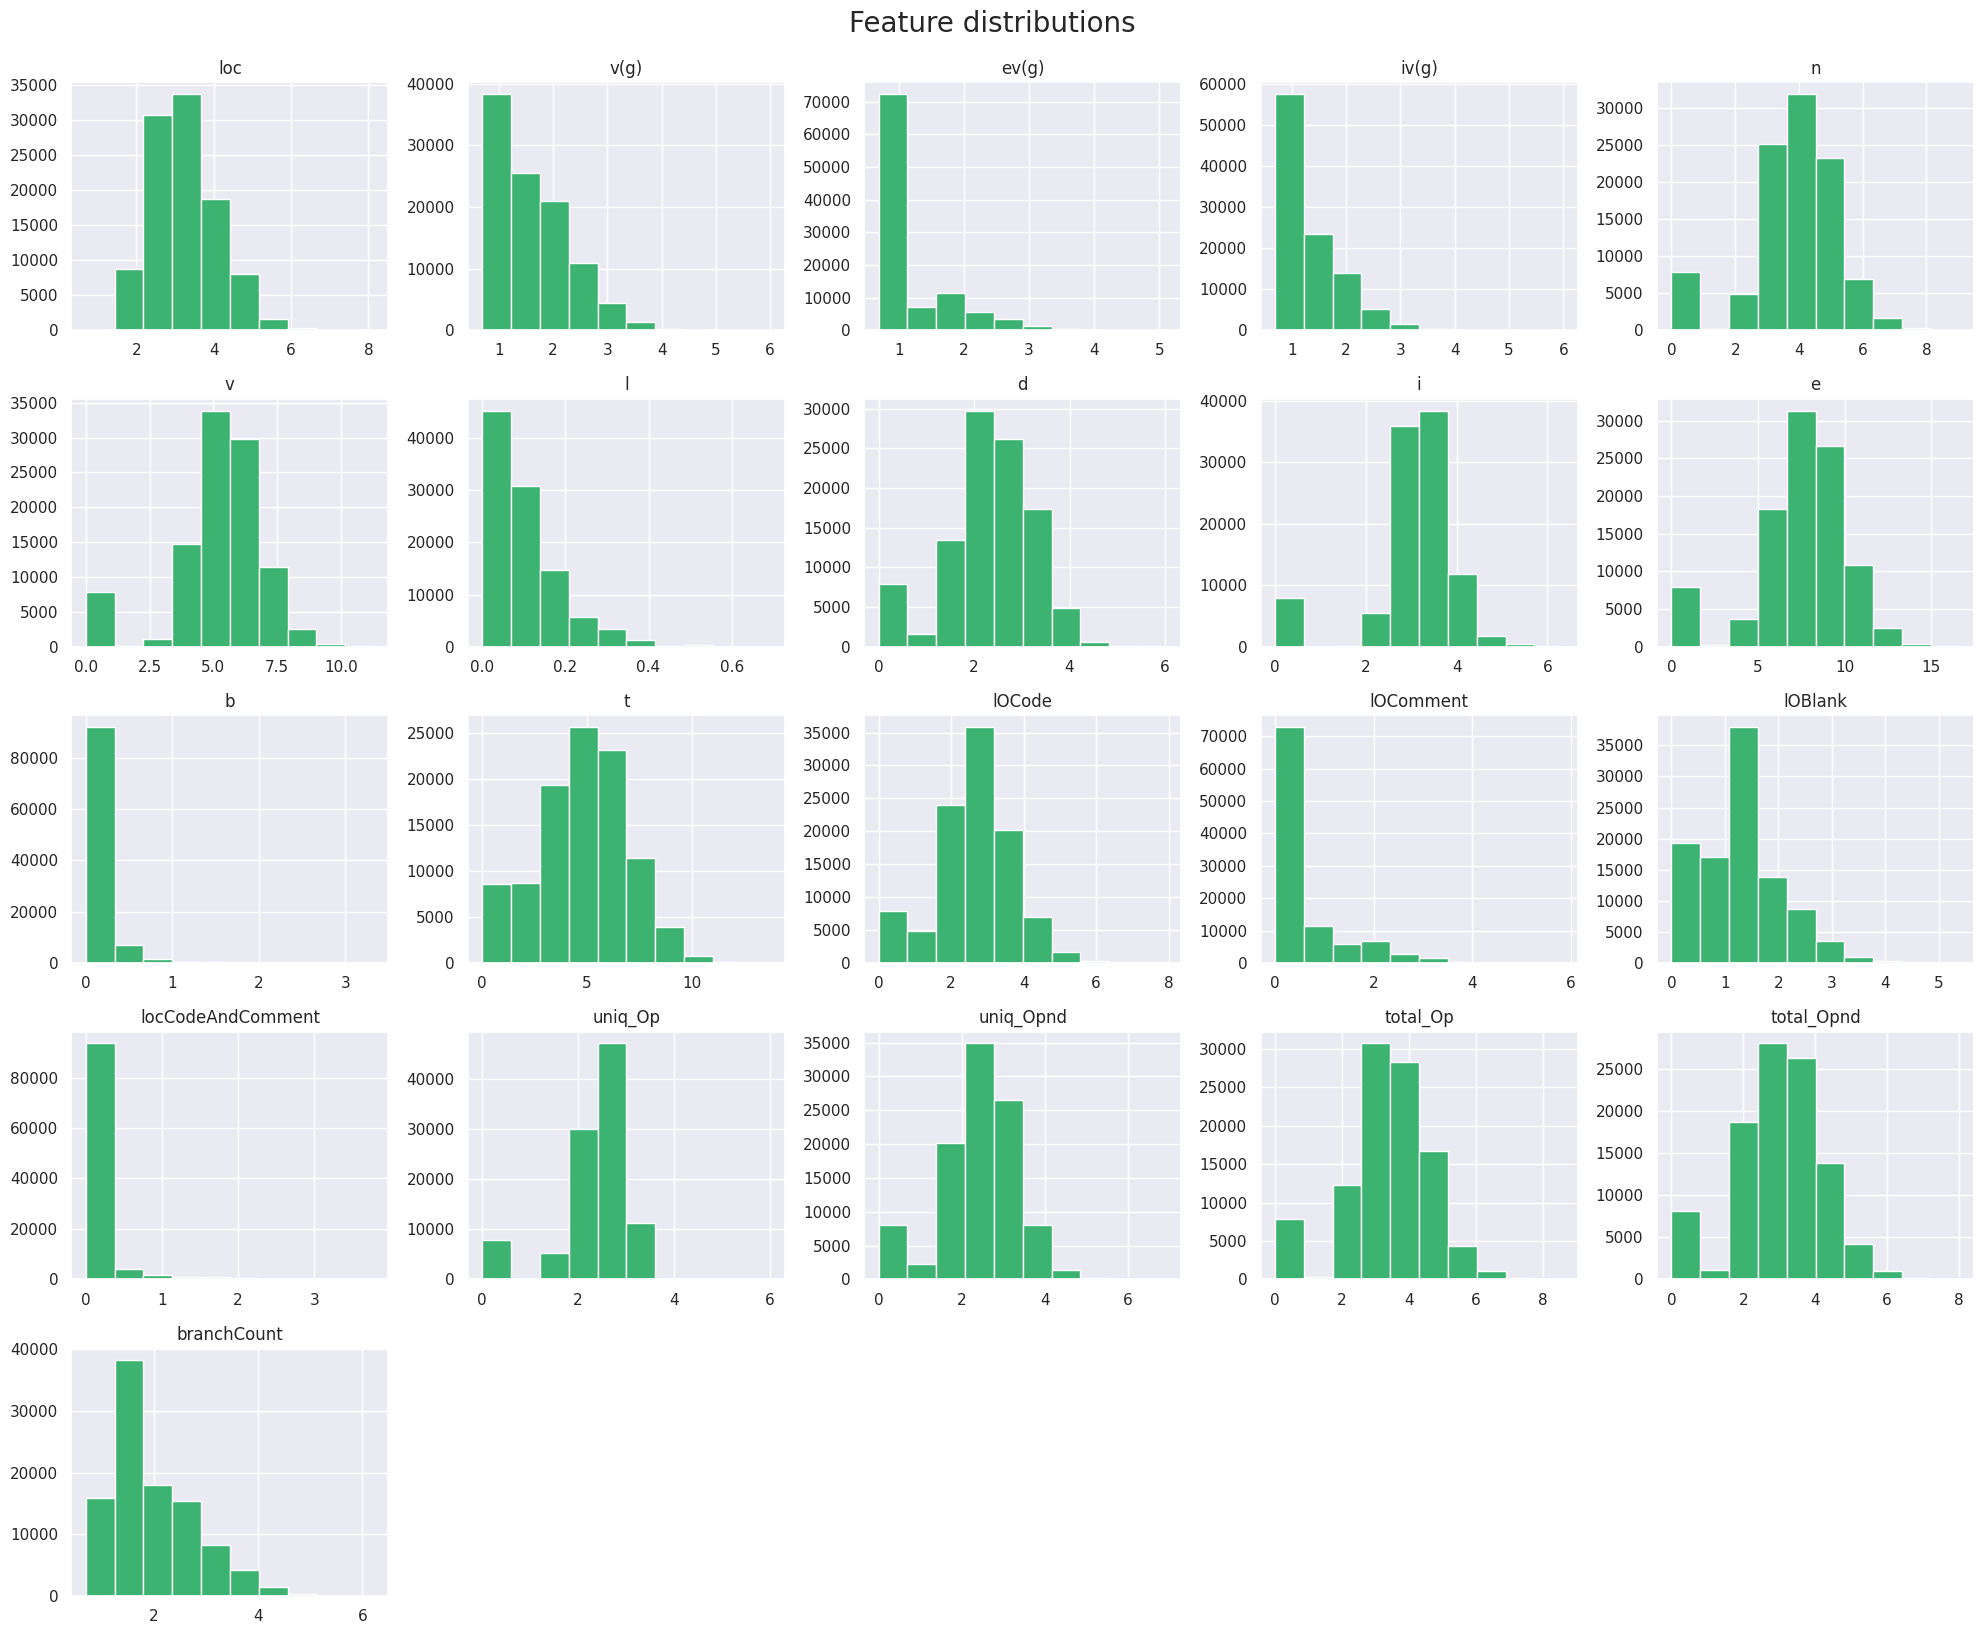

In [35]:
# 訓練データをX(説明変数)とy（目的変数）に分割する
X = train[numerical_features]
y = target

for column in X.columns.tolist():
    X[column] = X[column].apply(lambda x: np.log(x + 1))

X.hist(color='mediumseagreen')
plt.tight_layout()
plt.suptitle('Feature distributions', y=1.02, fontsize=20)
plt.show()

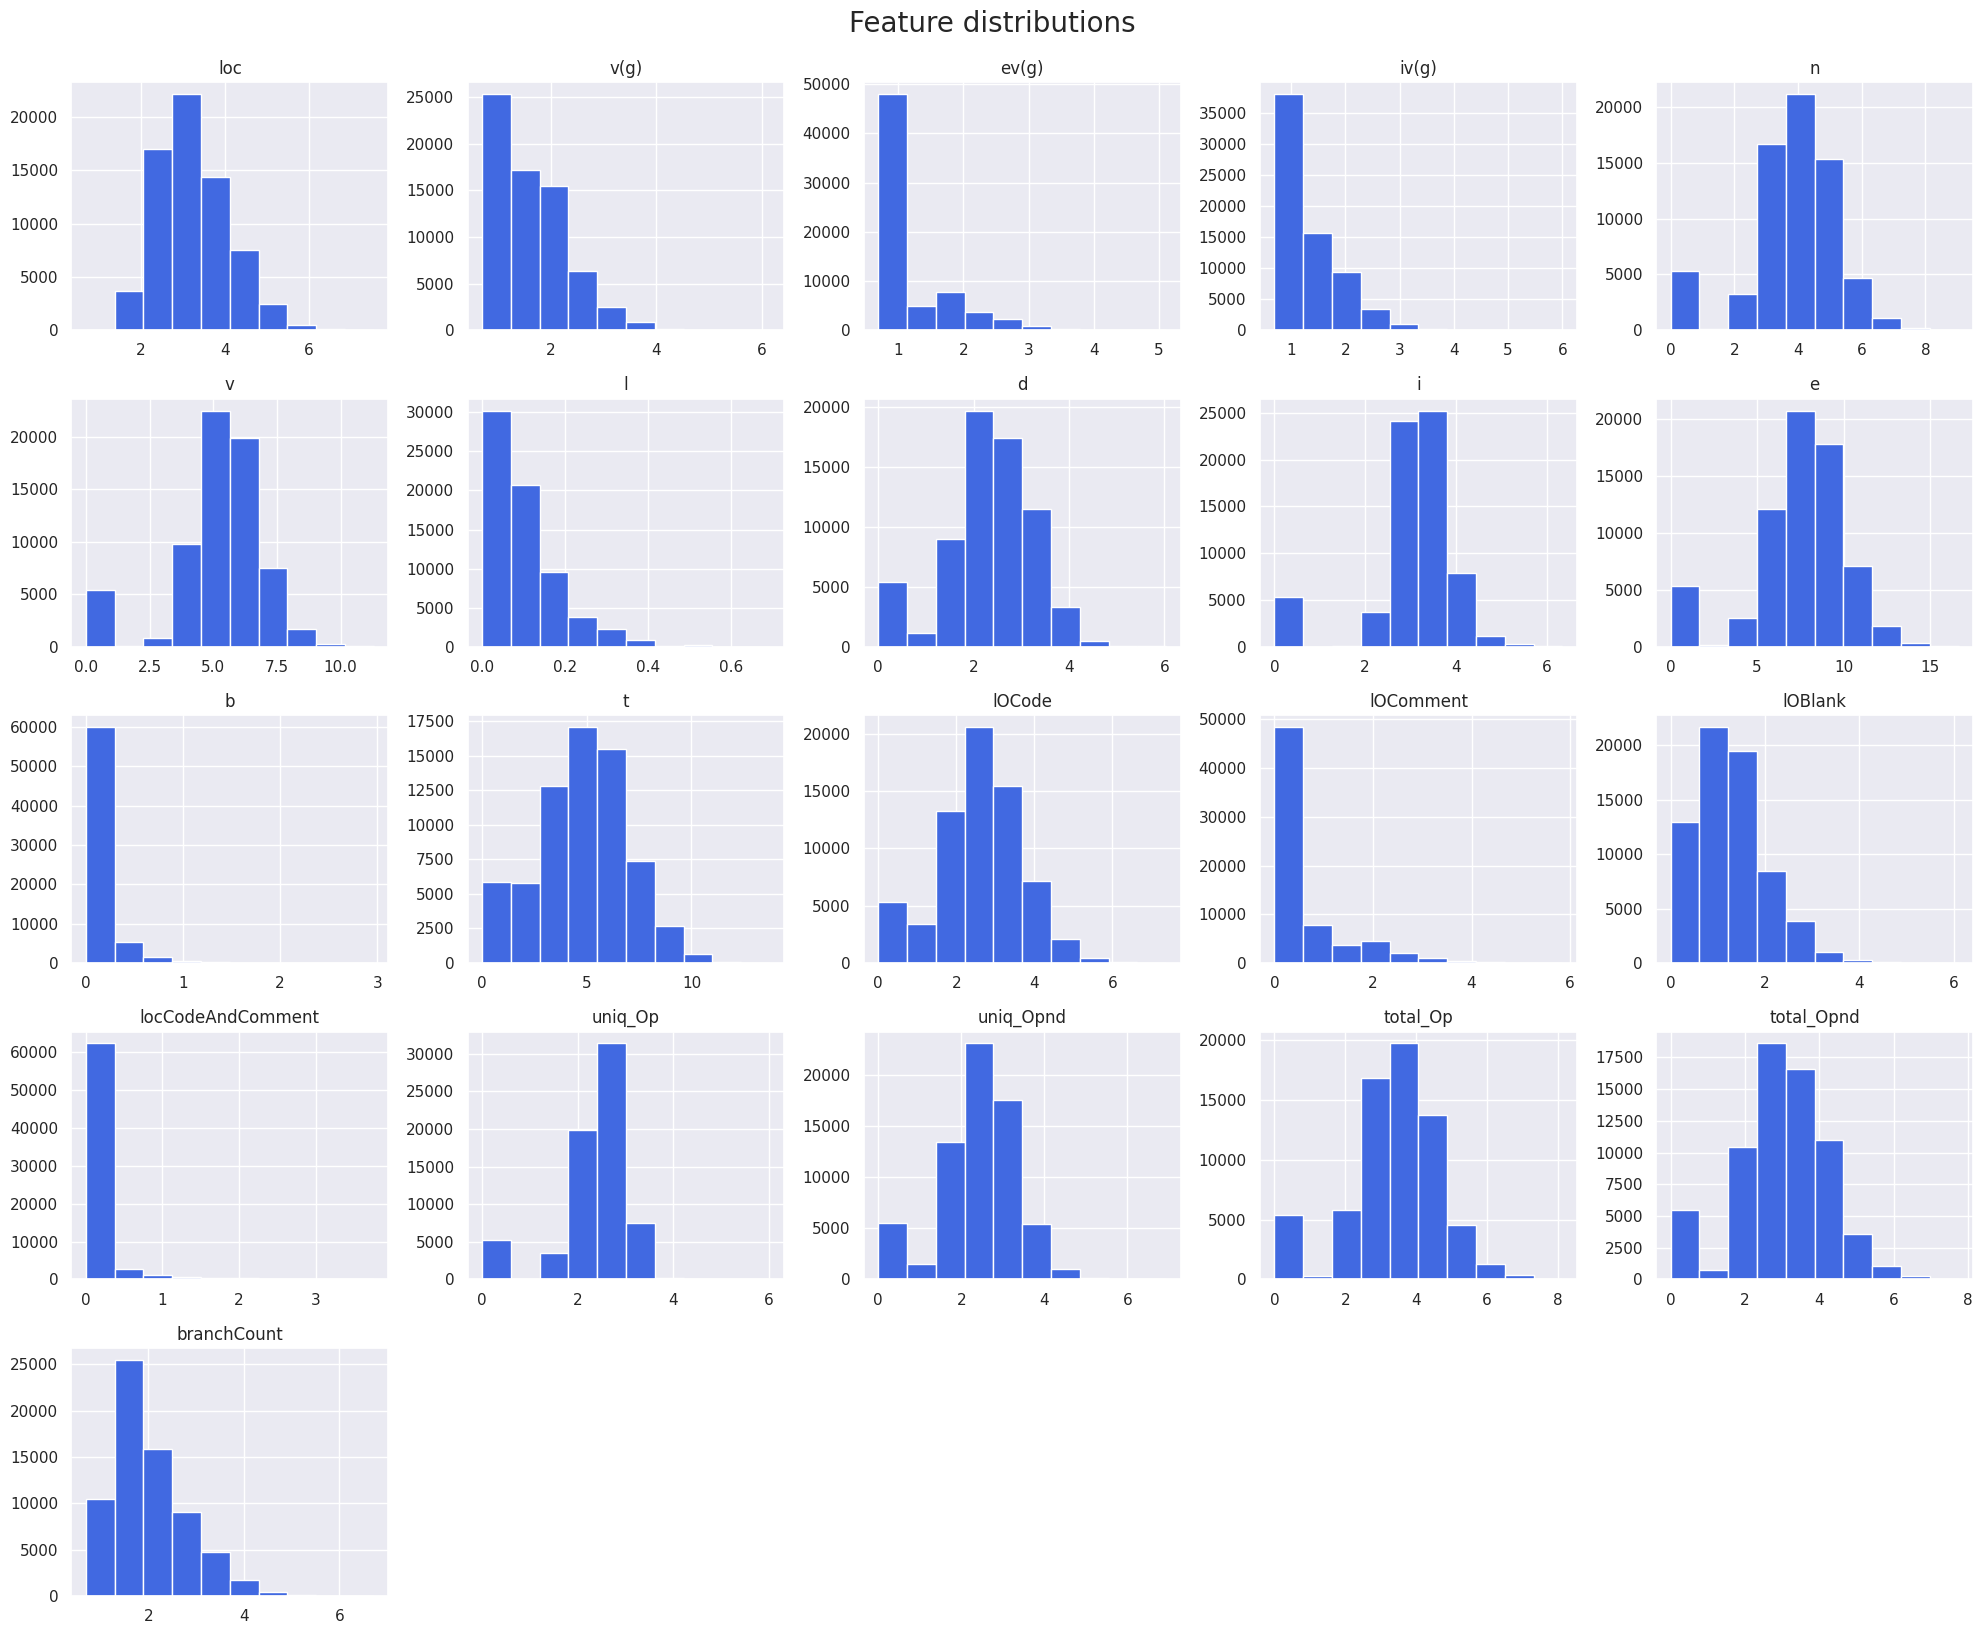

In [36]:
# テストデータも変換する
test_log = test[numerical_features]
for column in test_log.columns.tolist():
    test_log[column] = test_log[column].apply(lambda x: np.log(x + 1))

test_log.hist(color='royalblue')
plt.tight_layout()
plt.suptitle('Feature distributions', y=1.02, fontsize=20)
plt.show()

* 一部の説明変数において分布が確認しやすくなった
* このような分布の場合、`FunctionTransformer(np.log1p)`をパイプラインに前置することでデータを対数変換すると、多くのモデルが恩恵を受ける可能性がある

##### 数値型の説明変数の分布

カーネル密度推定（KDE: Kernel Density Estimation）
- 実データから、正規分布曲線のように下部の面積が1となるような連続した曲線（確率密度関数）を推定する

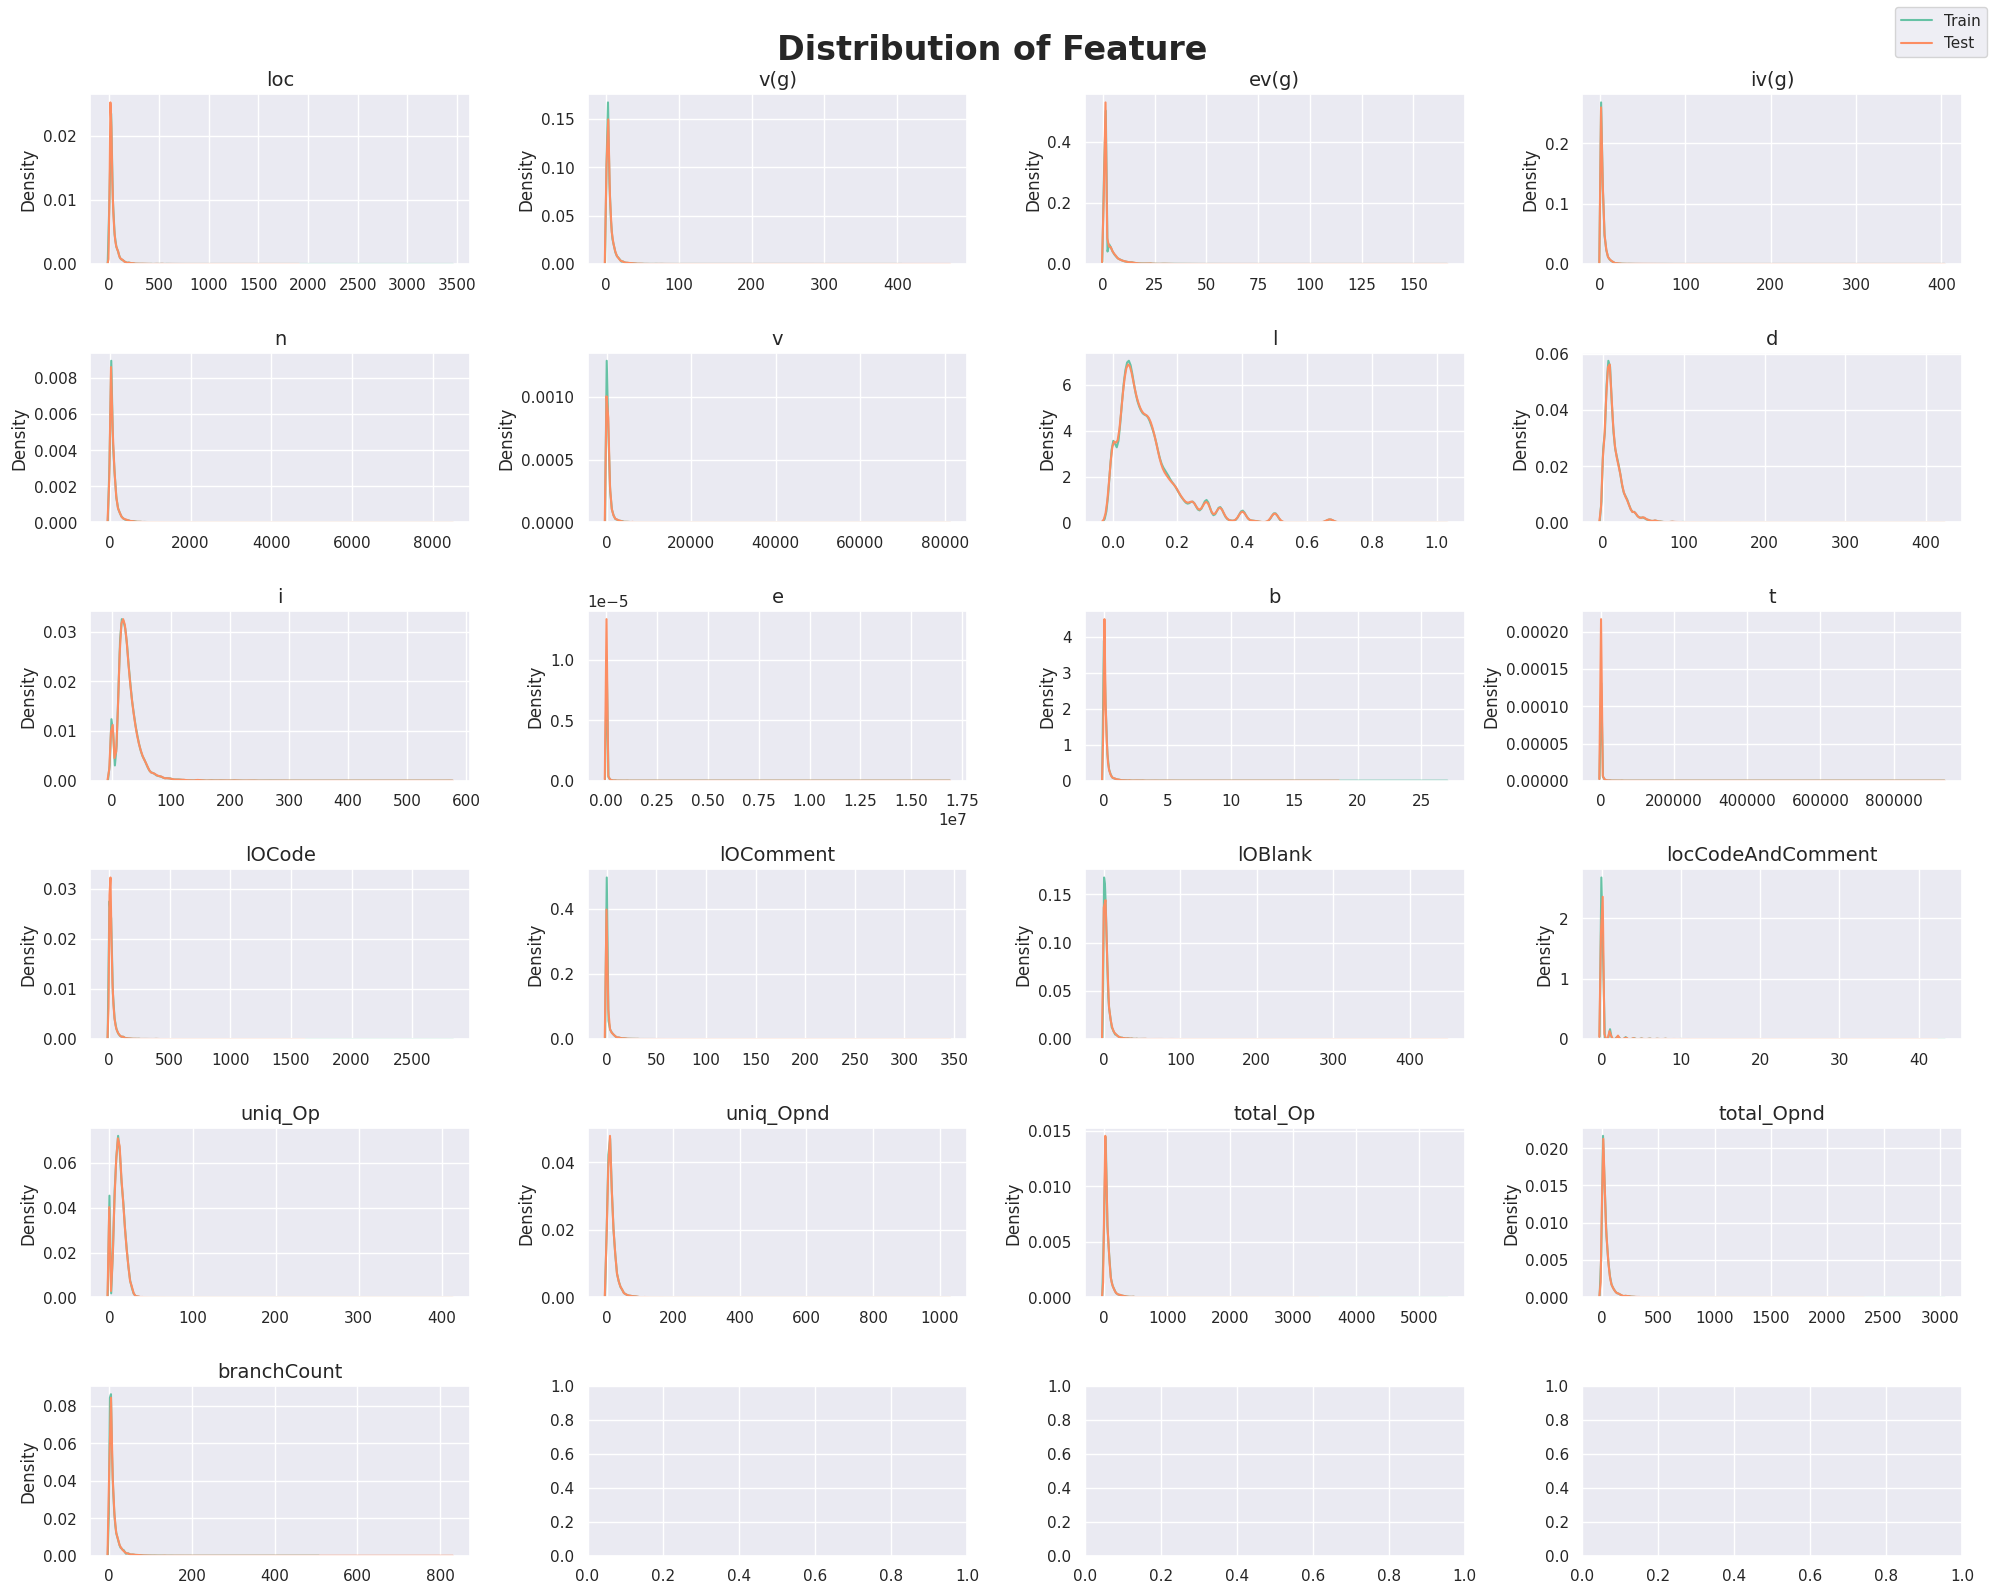

In [37]:
fig, ax = plt.subplots(len(numerical_features) // 4 + 1, 4)
ax = ax.flatten()
pal2 = sns.color_palette("Set2")
for i, column in enumerate(numerical_features):
    sns.kdeplot(train[column], ax=ax[i], color=pal2[0])
    sns.kdeplot(test[column], ax=ax[i], color=pal2[1], warn_singular=False)

    ax[i].set_title(f'{column}', size=14)
    ax[i].set_xlabel(None)

fig.suptitle('Distribution of Feature', fontsize=24, fontweight='bold')
fig.legend(['Train', 'Test'])
plt.tight_layout()

#### Adversarial Validation(敵対性の検証)

- Adversarial Validation(敵対性の検証)の目的
    - 訓練用のデータセットとテスト用データセットの間で値の分布に差があるかないかを検証すること
- もしもしこの検証の結果得られるROC-AUCスコアが0.5に近いようなら、二つのデータセットは同じ分布を持っていると考えていい
    - しかしその値が0.5から離れているようなら、分布が同様とは言えない

- 信頼できるCV（Cross-validation）スコアは同様の分布を持つデータセットからのみ取得されるため、あらかじめCVスコアが信頼できることを確認しておくためこの検証が必要

In [38]:
# 時間がかかるため、割愛
# def adversarial_validation(dataset_1=train, dataset_2 = test, label='Train-Test'):
#     adv_train = dataset_1.drop(target_col, axis=1)
#     adv_test = dataset_2.copy()

#     adv_train['is_test'] = 0
#     adv_test['is_test'] = 1

#     adv = pd.concat([adv_train, adv_test], ignore_index=True)
#     adv_shuffled = adv.sample(frac=1)
#     adv_X = adv_shuffled.drop('is_test', axis=1)
#     adv_y = adv_shuffled.is_test

#     skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
#     val_scores = []
#     predictions = np.zeros(len(adv))

#     for fold, (train_idx, val_idx) in enumerate(skf.split(adv_X, adv_y)):
#         adv_lr = make_pipeline(OneHotEncoder(cols=categorical_features), XGBClassifier(random_state=42))
#         adv_lr.fit(adv_X.iloc[train_idx], adv_y.iloc[train_idx])

#         val_preds = adv_lr.predict_proba(adv_X.iloc[val_idx])[:, 1]
#         predictions[val_idx] = val_preds
#         val_score = roc_auc_score(adv_y.iloc[val_idx], val_preds)
#         val_scores.append(val_score)

#     fpr, tpr, _ = roc_curve(adv['is_test'], predictions)

#     plt.figure(figsize=(10, 10), dpi=300)
#     sns.lineplot(x=[0, 1], y=[0, 1], linestyle="--", label="Indistinguishable Datasets")
#     sns.lineplot(x=fpr, y=tpr, label="Adversarial Validation Classifier")
#     plt.title(f'{label} Validation = {np.mean(val_scores):.5f}', weight='bold', size=17)
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.show()

# adversarial_validation()

## 円グラフと棒グラフ

### 円グラフと棒グラフ（目的変数）

defects
False    78699
True     23064
Name: count, dtype: int64


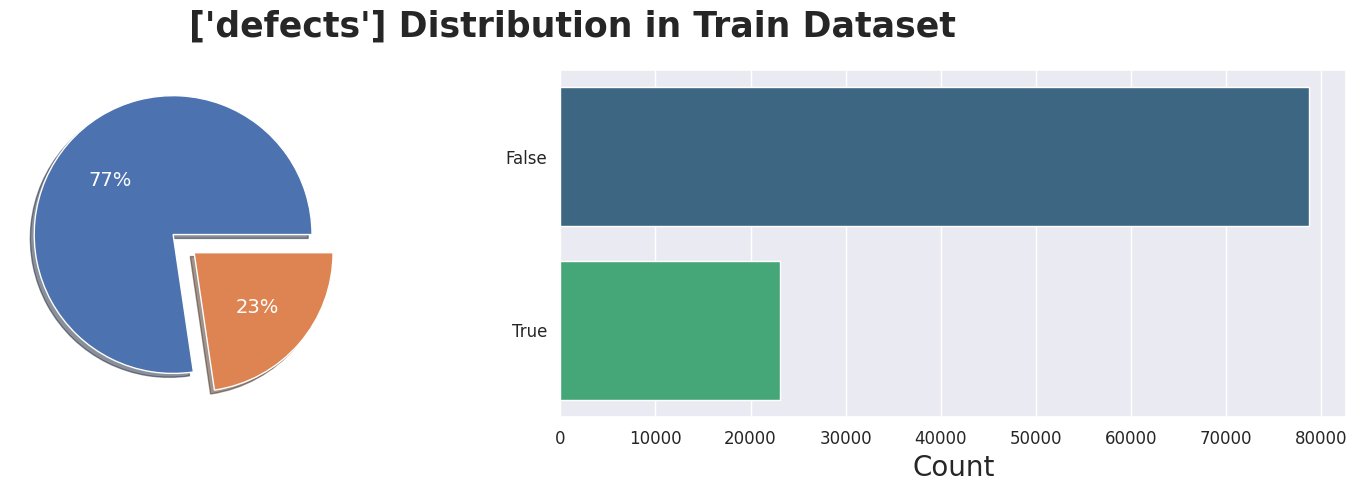

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
ax = ax.flatten()

ax[0].pie(
    target.value_counts(),
    shadow=True,
    explode=[.1 for i in range(target.nunique())],
    autopct='%1.f%%',
    textprops={'size': 14, 'color':'white'}
)

sns.countplot(data=train, y=target_col, ax=ax[1], palette='viridis', order=train[target_col].value_counts().index)
ax[1].yaxis.label.set_size(20)
plt.yticks(fontsize=12)
ax[1].set_xlabel('Count', fontsize=20)
ax[1].set_ylabel(None)
plt.xticks(fontsize=12)

fig.suptitle(target_name + ' Distribution in Train Dataset', fontsize=25, fontweight='bold')
plt.tight_layout()

# 目的変数を数える
print(f'{train[target_col].value_counts()}')

### 箱ひげ図

数値型の説明変数

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

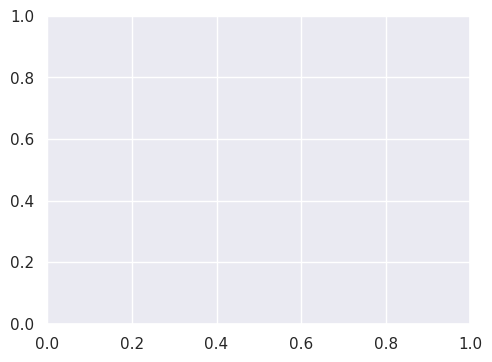

In [40]:
for feat in numerical_features:
    plt.figure(figsize=(12, 4))
    ax1 = plt.subplot(1, 2, 1)
    sns.boxplot(data=train, x=target, y=feat)
    plt.title(target_name + ' vs ' + feat + ' / train')
    x1 = plt.subplot(1, 2, 2)
    sns.boxplot(data=test, y=feat)
    plt.title(feat + ' / test')
    plt.show()

#### 箱ひげ図（目的変数）

In [ ]:
# データの範囲を調べる
plt.figure(figsize=(10, 8))
plt.boxplot(target, showmeans=True, meanline=True)
plt.title('Data range of ' + target_name)
plt.grid(True)

In [ ]:
# バイオリンプロット
plt.figure(figsize=(10, 8))
plt.violinplot(target, showmedians=True) # 中央値をマーキングする
plt.title('Violin plot of ' + target_name)
plt.grid(True)

In [ ]:
# 目的変数と'i'（最も特徴重要度の高い説明変数）との関係
train_most_important_value = 'i' # 説明変数を指定する
categorical_variate_corr = pd.concat([target, train[train_most_important_value]], axis=1)
f, ax = plt.subplots(figsize=(18, 6))
fig = sns.boxplot(x=target, y=train_most_important_value, data=categorical_variate_corr)
fig.axis();

### 特徴量の重要度評価

CPU times: user 4.28 s, sys: 601 ms, total: 4.88 s
Wall time: 1.99 s


<Axes: >

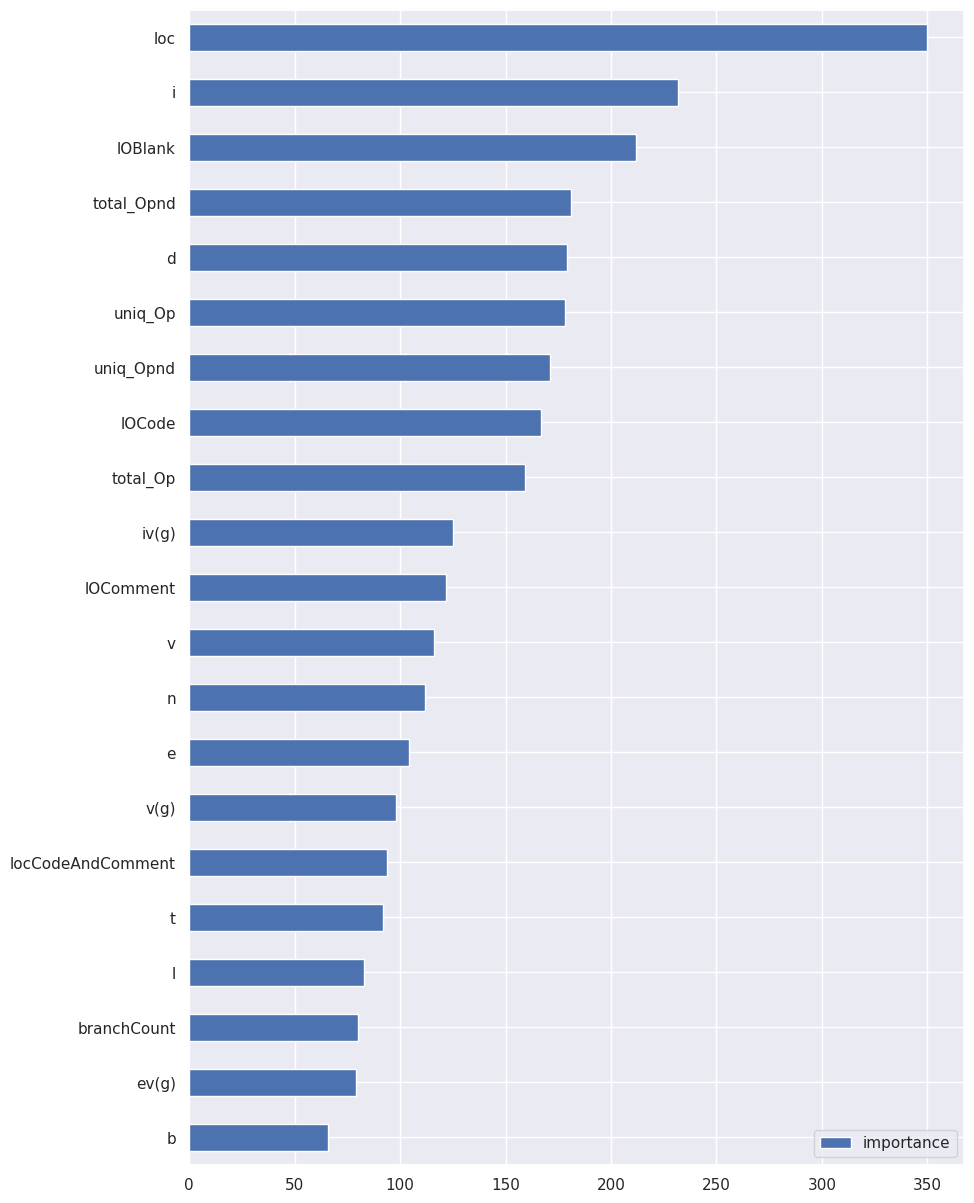

In [41]:
%%time

lgb = LGBMClassifier(
    random_state=42,
)

lgb.fit(X, y)
importance = lgb.feature_importances_

feature_importance = pd.DataFrame(data=importance, index=X.columns, columns=['importance']) \
    .sort_values(ascending=True, by='importance')

feature_importance.plot(kind='barh', figsize=(10, 15), color='b')

In [42]:
feature_importance

,importance
b,66
ev(g),79
branchCount,80
l,83
t,92
locCodeAndComment,94
v(g),98
e,104
n,112
v,116


考察
* 'loc', 'i'の重要度が特に高い
* 'l', 'b'が低い

### 相関（ヒートマップ）

<Axes: >

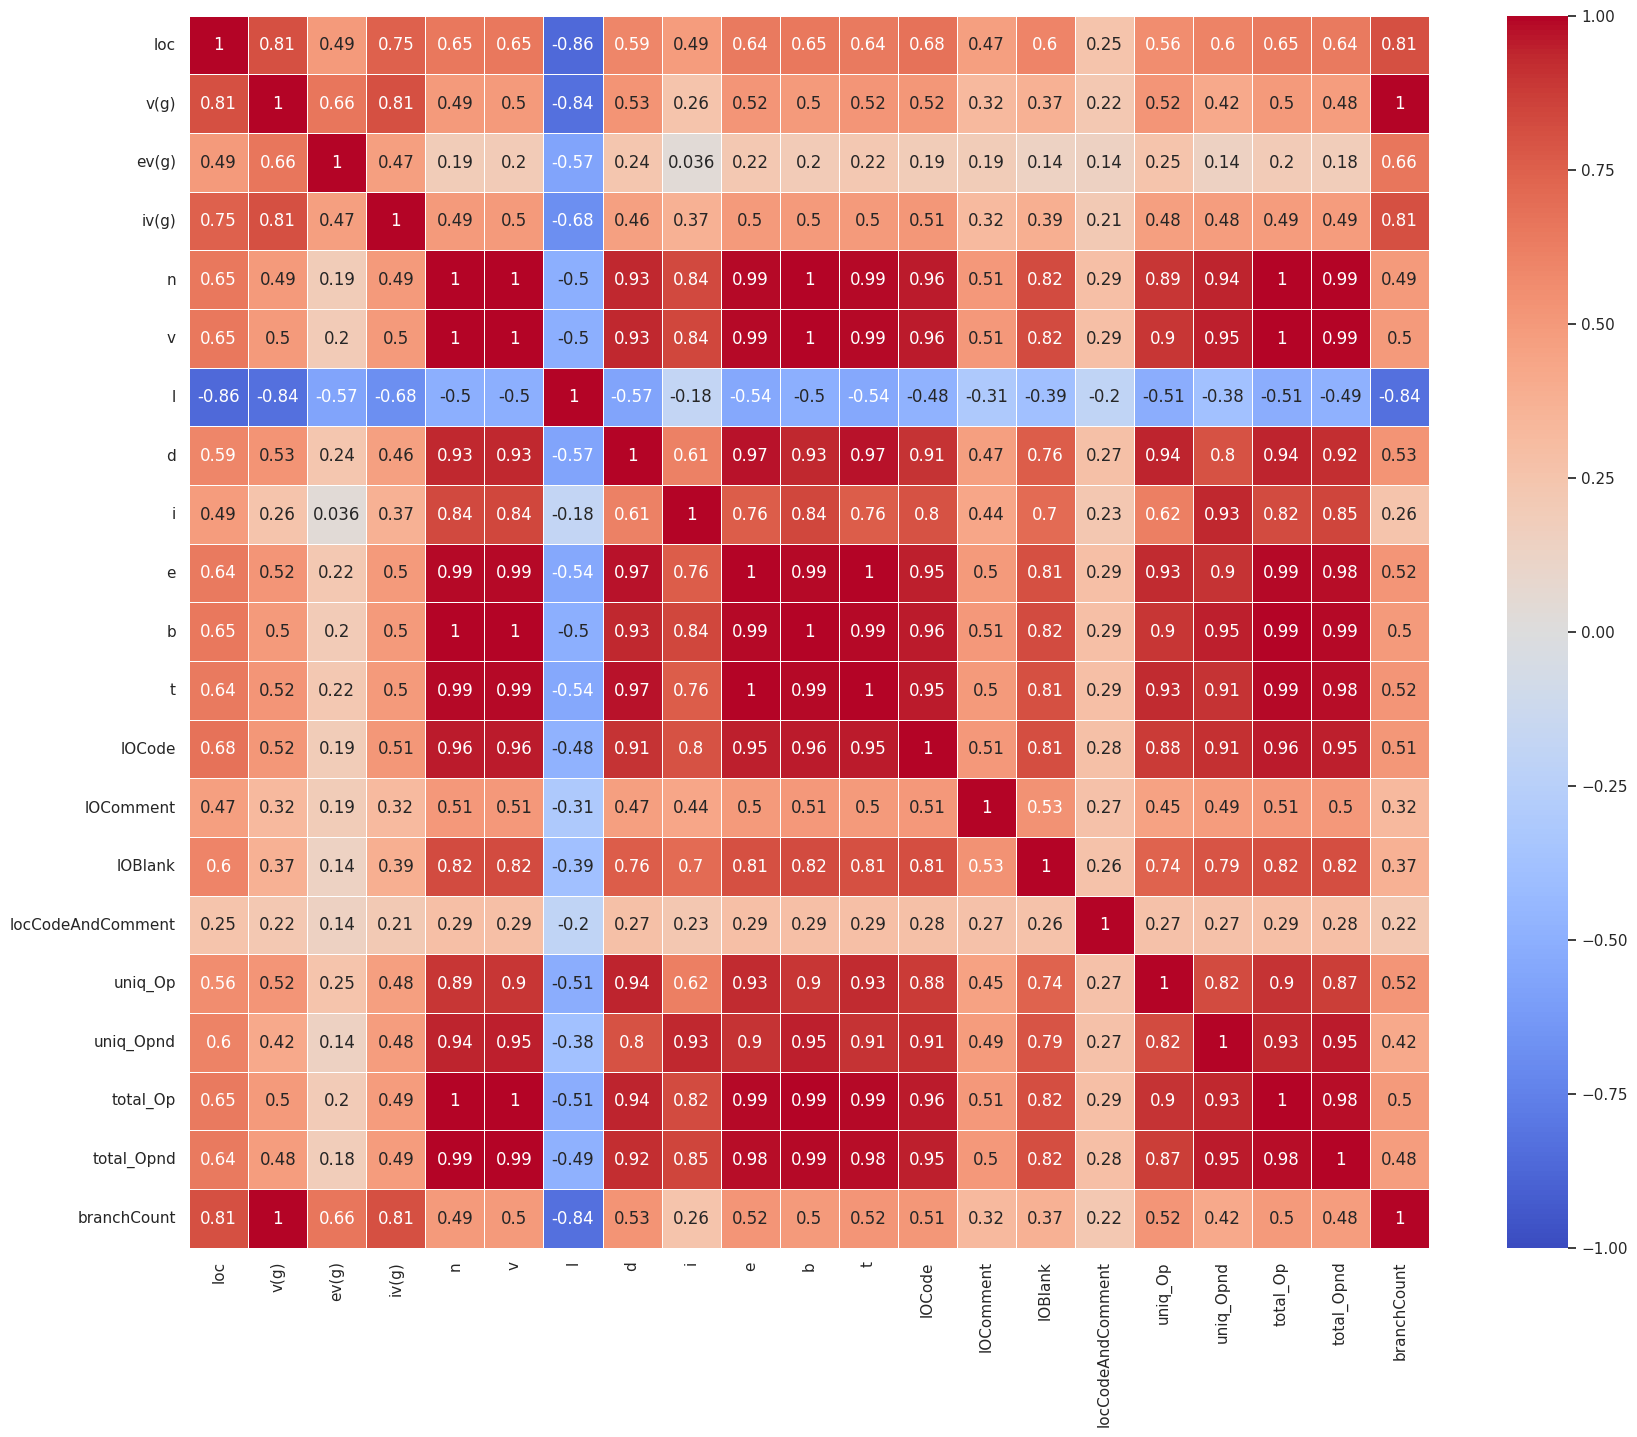

In [43]:
corr = train[numerical_features].corr(method='spearman')
plt.figure()
sns.heatmap(corr, linewidth=0.5, square=False, annot=True, cmap="coolwarm", vmin=-1, vmax=1)

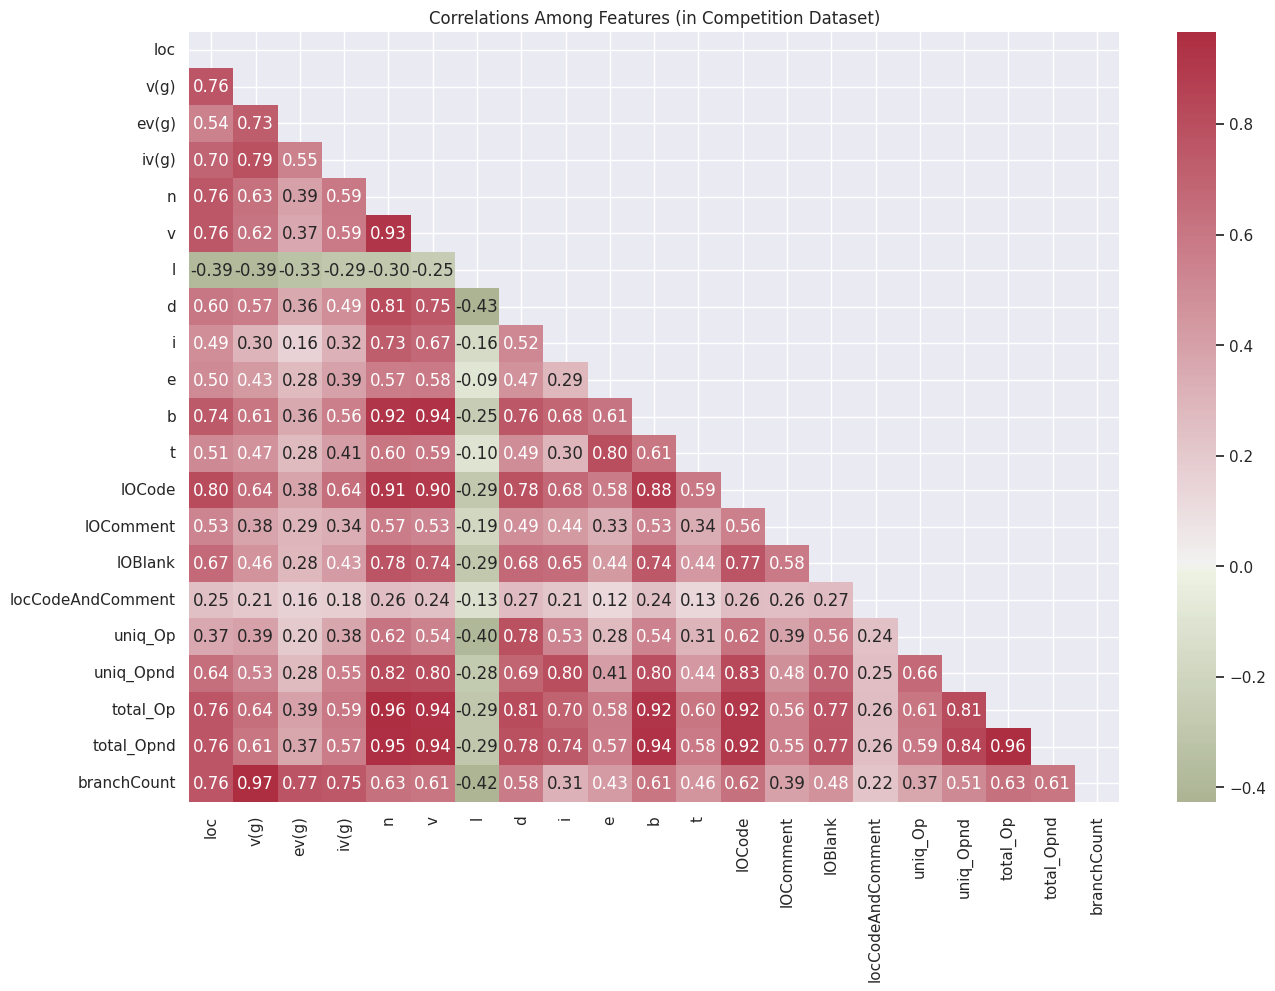

In [44]:
corr_mat_data = train[numerical_features].corr()
data_mask = np.triu(np.ones_like(corr_mat_data, dtype=bool))

cmap = sns.diverging_palette(100, 7, s=75, l=40, n=5, center='light', as_cmap=True)

plt.figure(figsize=(15, 10))
sns.heatmap(corr_mat_data, annot=True, cmap=cmap, fmt='.2f', center=0,
            annot_kws={'size': 12}, mask=data_mask).set_title('Correlations Among Features (in Competition Dataset)');

調べた結果を記述する
* 相関係数が1の組み合わせ
    - 'branchCount', 'v(g)'
    - 'n', 'v', 'b', 'total_Op'(bとは0.99)
    - 'e', 't'

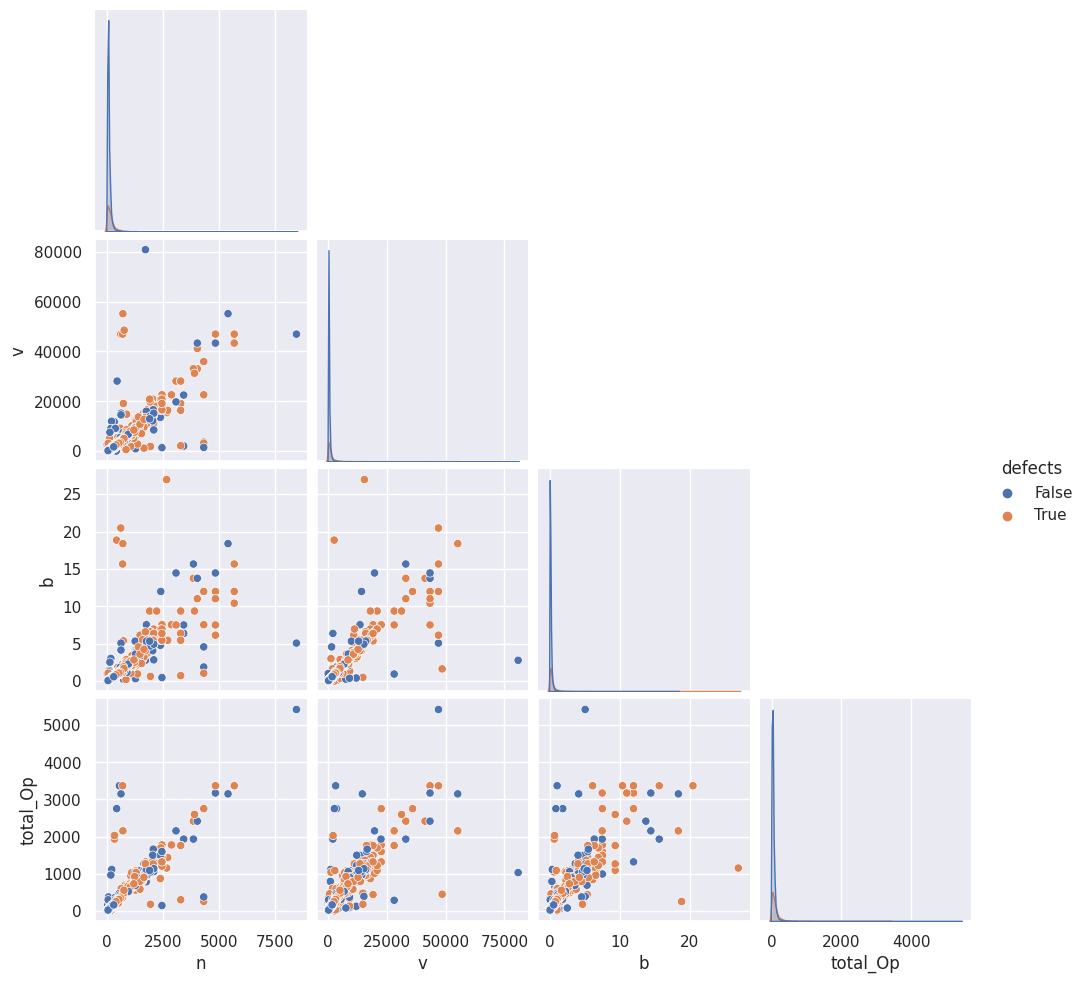

In [45]:
# 'n', 'v', 'b', 'total_Op'とdefects(目的変数)との相関関係を調べる
sns.pairplot(data=train[['n', 'v', 'b', 'total_Op', 'defects']], hue='defects', corner=True);

In [46]:
# 目的変数との相関の値が高い順に表示する
corr_target_data = train.corr()[target_col] # 目的変数を指定する
corr_target_data.sort_values(ascending=False)

defects              1.00000
loc                  0.34264
branchCount          0.32283
v(g)                 0.30119
ev(g)                0.25993
n                    0.25808
lOBlank              0.25782
total_Opnd           0.25275
lOCode               0.25060
total_Op             0.25053
uniq_Opnd            0.24611
iv(g)                0.24562
d                    0.24194
b                    0.23259
v                    0.23118
i                    0.20858
lOComment            0.20540
uniq_Op              0.17847
locCodeAndComment    0.13315
t                    0.09959
e                    0.09537
l                   -0.25324
Name: defects, dtype: float64

In [48]:
# 目的変数と最も相関係数が高い説明変数の値ごとのデータ数を数える
corr_1_size = train.groupby('loc').size() # 説明変数を指定する
corr_1_size.sort_values(ascending=False).head(10)

loc
11.00000    3657
12.00000    3431
7.00000     3426
17.00000    3255
8.00000     3109
10.00000    3084
14.00000    3083
15.00000    2935
9.00000     2797
13.00000    2713
dtype: int64

### 階層的クラスタリング

- 特徴間の関係の強さと方向性を調べる
- 特徴をクラスタリングする

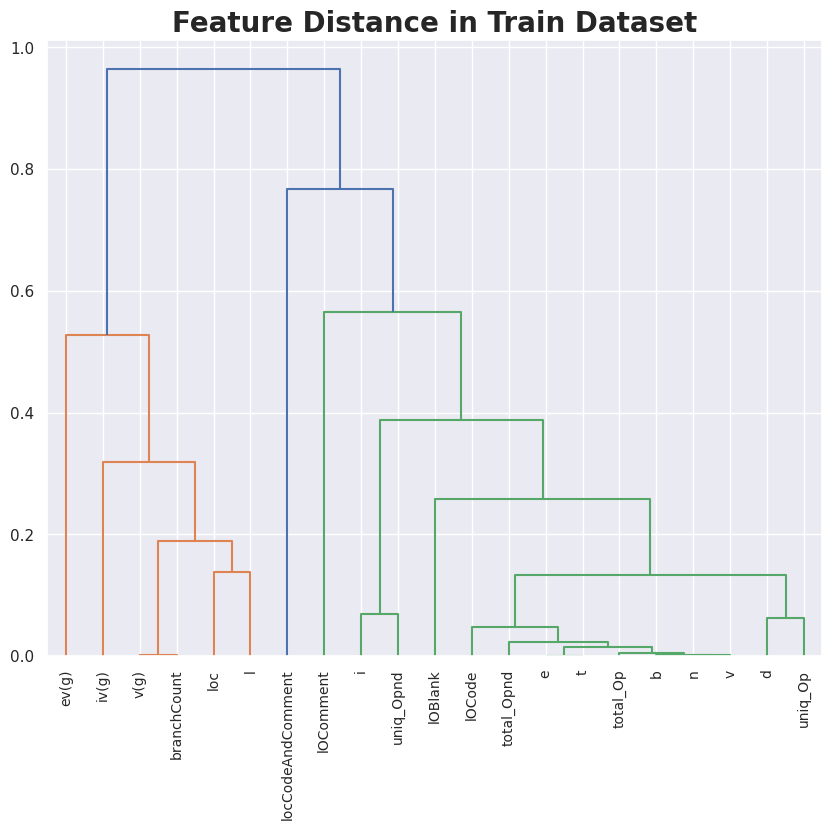

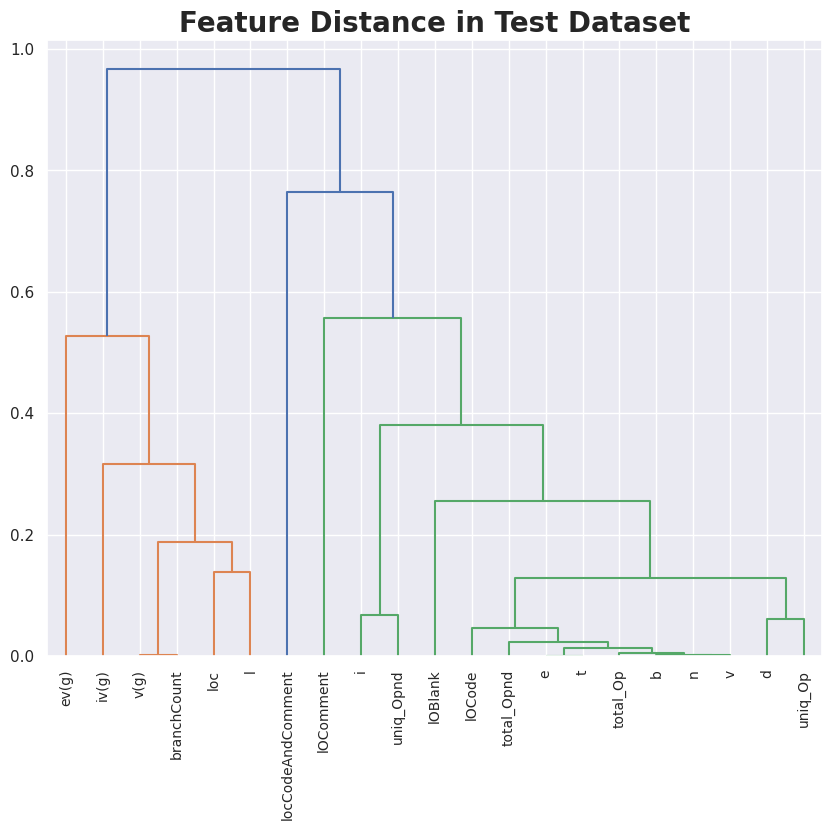

In [49]:
def distance(data, label = ''):
    corr = data.corr(method='spearman')
    dist_linkage = linkage(squareform(1 - abs(corr)), 'complete')

    plt.figure(figsize=(10, 8))
    dendro = dendrogram(dist_linkage, labels=data.columns, leaf_rotation=90)
    plt.title(f'Feature Distance in {label} Dataset', weight='bold', size=20)
    plt.show()

distance(train[numerical_features], 'Train')
distance(test[numerical_features], 'Test')

## EDAの可視化するためのライブラリ

### sweetviz

In [50]:
report = sv.compare([train, "Train"], [test, "Test"])
report.show_html(OUTPUT_DIR + "EDA_sweetviz.html")

                                             |          | [  0%]   00:00 -> (? left)

Report /kaggle/working/EDA_sweetviz.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


## 実行時間を調べるために使う

In [51]:
end_time = time.time()
lap = end_time - start_time
indi_time = changeHMS(lap)
indi_time

'15m36s'